# Introduction

This notebook investigates a dataset of data from property sales in King County, Seattle between May 2014 and May 2015 (<https://www.kaggle.com/datasets/minasameh55/king-country-houses-aa>).
The goal is to predict sales prices based on the dataset in order to practice and experiment with supervised machine learning approaches.

# Preparation

In [2822]:
# downloading and unzipping the dataset
# uncomment to redownload
# might not work directly on non-Unix systems, in that case simply download manually and extract to the data folder

#! curl -L -o data/data.zip https://www.kaggle.com/api/v1/datasets/download/minasameh55/king-country-houses-aa
#! unzip data/data.zip -d data/

In [2823]:
# import analysis and visualisation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2824]:
# import ML libraries
# Load libraries
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn models and metrics
from sklearn import linear_model, ensemble, metrics

# scaler
from sklearn.preprocessing import StandardScaler,OneHotEncoder



In [2825]:
# visualisation settings

# allow unlimited scrollability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set_theme(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")


In [2826]:
from IPython.display import display, HTML

def display_scrollable_df(df, height=400):
    html = f'''
    <div style="max-height:{height}px; overflow:auto; display:block; border:1px solid #ccc">
        {df.to_html(max_rows=None, max_cols=None)}
    </div>
    '''
    display(HTML(html))

In [2827]:
# disable scientific number notation

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.use_mathtext'] = False

# suppress scientific notation by setting float_format
pd.set_option('display.float_format', '{:.6f}'.format)


In [2828]:
# load dataset
# note that the csv-filename contains a typo with "country" instead of county and superfluous spaces
# I leave this unchanged, since it is only relevant in this very cell

housing = pd.read_csv('data/king_ country_ houses_aa.csv')

## Metrics repository

I am setting up a lists for saving core metrics and parameters for later comparison in dataframes.

In [2829]:
lm_result_lst = []
knn_result_lst = []
rf_result_lst = []
gradboost_result_lst = []
xgb_result_lst = []     # for more detailed listing of xgboost results for fine-tuning

overall_results = pd.DataFrame()

# EDA

In [2830]:
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000000,3,1.000000,1180,5650,1.000000,0,0,3,7,1180,0,1955,0,98178,47.511200,-122.257000,1340,5650
1,6414100192,20141209T000000,538000.000000,3,2.250000,2570,7242,2.000000,0,0,3,7,2170,400,1951,1991,98125,47.721000,-122.319000,1690,7639
2,5631500400,20150225T000000,180000.000000,2,1.000000,770,10000,1.000000,0,0,3,6,770,0,1933,0,98028,47.737900,-122.233000,2720,8062
3,2487200875,20141209T000000,604000.000000,4,3.000000,1960,5000,1.000000,0,0,5,7,1050,910,1965,0,98136,47.520800,-122.393000,1360,5000
4,1954400510,20150218T000000,510000.000000,3,2.000000,1680,8080,1.000000,0,0,3,8,1680,0,1987,0,98074,47.616800,-122.045000,1800,7503


Here's the description of the columns:

The description for the 20 features is given below:

- id :- It is the unique numeric number assigned to each house being sold.
- date :- It is the date on which the house was sold out.
- price:- It is the price of house which we have to predict so this is our target variable and aprat from it are our features.
- bedrooms :- It determines number of bedrooms in a house.
- bathrooms :- It determines number of bathrooms in a bedroom of a house.
- sqft_living :- It is the measurement variable which determines the measurement of house in square foot.
- sqft_lot : It is also the measurement variable which determines square foot of the lot.
- floors: It determines total floors means levels of house.
- waterfront : This feature determines whether a house has a view to waterfront 0 means no 1 means yes.
- view : This feature determines whether a house has been viewed or not 0 means no 1 means yes.
- condition : It determines the overall condition of a house on a scale of 1 to 5.
- grade : It determines the overall grade given to the housing unit, based on King County grading system on a scale of 1 to 11
- sqft_above : It determines square footage of house apart from basement.
- sqft_basement : It determines square footage of the basement of the house.
- yr_built : It detrmines the date of building of the house.
- yr_renovated : It detrmines year of renovation of house.
- zipcode : It determines the zipcode of the location of the house.
- lat : It determines the latitude of the location of the house.
- long : It determines the longitude of the location of the house.
- sqft_living15 : Living room area in 2015(implies-- some renovations)
- sqft_lot15 : lotSize area in 2015(implies-- some renovations)

In [2831]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [2832]:
display(housing.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,21613.000000,4580301520.864988,2876565571.312057,1000102.000000,2123049194.000000,3904930410.000000,7308900445.000000,9900000190.000000
price,21613.000000,540088.141767,367127.196483,75000.000000,321950.000000,450000.000000,645000.000000,7700000.000000
bedrooms,21613.000000,3.370842,0.930062,0.000000,3.000000,3.000000,4.000000,33.000000
bathrooms,21613.000000,2.114757,0.770163,0.000000,1.750000,2.250000,2.500000,8.000000
sqft_living,21613.000000,2079.899736,918.440897,290.000000,1427.000000,1910.000000,2550.000000,13540.000000
sqft_lot,21613.000000,15106.967566,41420.511515,520.000000,5040.000000,7618.000000,10688.000000,1651359.000000
floors,21613.000000,1.494309,0.539989,1.000000,1.000000,1.500000,2.000000,3.500000
waterfront,21613.000000,0.007542,0.086517,0.000000,0.000000,0.000000,0.000000,1.000000
view,21613.000000,0.234303,0.766318,0.000000,0.000000,0.000000,0.000000,4.000000
condition,21613.000000,3.409430,0.650743,1.000000,3.000000,3.000000,4.000000,5.000000


In [2833]:
housing.zipcode.value_counts()

zipcode
98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: count, Length: 70, dtype: int64

In [2834]:
housing.yr_renovated.value_counts()

yr_renovated
0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1948        1
1951        1
1959        1
1934        1
1944        1
Name: count, Length: 70, dtype: int64

There are 21613 data rows and 20 columns. The first is an id, followed by the date of the transaction and the target variable `price`. The remaining variables concern characteristics of the property, its location and work carried out on it.

The target variable price ranges between 75k and 7.7mln with a mean of 540k and a median of 450k.

The datatypes seem appropriate overall and almost all of them are numerical (except for date), which is a good basis for applying models later on. 

Notes:

- `date` can be converted into datetime and in fact it might be enough to extract month (and maybe day?) of sale, since the data only covers a timespan of one year anyway (albeit spanning 2 calendar years).
- minor inconsistencies: 
  - `grade` is described as having a scale of 1--11 in the metadata, but the data seem to contain values up to 13.
  - `view` actually goes up to 4, so probably indicates the number of viewings (by the buyer or in general?) rather than a binary value as suggested by the meta-data. I won't worry about this for now. Could be a candidate for dropping later if it turns out to be not relevant
- Converting `floors` using one-hot-encoding may be misleading, since a house with 4 floors, necessarily also has 1, 2 and 3 floors? Possibly consider if this might pose a problem.
- The `sqft_[living|lot]15` variables are interesting in that they seem to provide some sort of dynamic/time related data. However, I am slightly confused by the significance of these data for the sales price, particularly if the sale data was in 2014. In fact, even for 2015 sales it is not clear if those implied renovations were carried out before or after sale. It could also be that these columns generally encode renovations after sale and therefore provide hints as to investments needed (?), which could influence the sale price? However, pending a clearer understanding of these columns, this is entirely speculative. 
- Including geographical data like zipcodes or lat/long seems like a good idea for modelling. Including both might involve collinearity, which could be worth checking later. 
  - The zipcodes in particular raise the question of whether some kind of binning would be feasible, since there are 70 distinct categories. This might speak in favour of using lat/long, which are continuous and where distance measures are more straightforward.
- `sqft_basement` and `yr_renovated` both include 0 values to indicate the absence of the relevant feature. This might be conceptually plausible in `sqft_basement`, since an absent basement has an area of 0, but not so much for `yr_renovated` -- those properties presumably lack any information on renovation, rather than having been renovated over 2000 years ago. In both cases, the 0 values certainly influence the overall distribution, especially since the median is actually 0 for both variables. This is worth further exploration later.
  - Given the high prevalence of null values in `yr_renovated` and the presumably long tail, binning might be appropriate.  



In [2835]:
housing.view.value_counts()

view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64

In [2836]:
# probably the grading scale really goes up to 13, otherwise the numbers of 12 and 13 ratings would seem too big for accidental entries 
housing.grade.value_counts()

grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: count, dtype: int64

## Checks

### Check for null values

In [2837]:
housing.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

There are no null values, splendid.

### Check for duplicates

In [2838]:
housing[housing['id'].duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
94,6021501535,20141223T000000,700000.000000,3,1.500000,1580,5000,1.000000,0,0,3,8,1290,290,1939,0,98117,47.687000,-122.386000,1570,4500
314,4139480200,20141209T000000,1400000.000000,4,3.250000,4290,12103,1.000000,0,3,3,11,2690,1600,1997,0,98006,47.550300,-122.102000,3860,11244
325,7520000520,20150311T000000,240500.000000,2,1.000000,1240,12092,1.000000,0,0,3,6,960,280,1922,1984,98146,47.495700,-122.352000,1820,7460
346,3969300030,20141229T000000,239900.000000,4,1.000000,1000,7134,1.000000,0,0,3,6,1000,0,1943,0,98178,47.489700,-122.240000,1020,7138
372,2231500030,20150324T000000,530000.000000,4,2.250000,2180,10754,1.000000,0,0,5,7,1100,1080,1954,0,98133,47.771100,-122.341000,1810,6929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181,7853400250,20150219T000000,645000.000000,4,3.500000,2910,5260,2.000000,0,0,3,9,2910,0,2012,0,98065,47.516800,-121.883000,2910,5260
20613,2724049222,20141201T000000,220000.000000,2,2.500000,1000,1092,2.000000,0,0,3,7,990,10,2004,0,98118,47.541900,-122.271000,1330,1466
20670,8564860270,20150330T000000,502000.000000,4,2.500000,2680,5539,2.000000,0,0,3,8,2680,0,2013,0,98045,47.475900,-121.734000,2680,5992
20780,6300000226,20150504T000000,380000.000000,4,1.000000,1200,2171,1.500000,0,0,3,7,1200,0,1933,0,98133,47.707600,-122.342000,1130,1598


We seem to have 177 rows with duplicate data. Let's have a closer look:

In [2839]:
# double check two random instances
display(housing.loc[housing.id == 6021501535])
display(housing.loc[housing.id == 3969300030])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,20140725T000000,430000.000000,3,1.500000,1580,5000,1.000000,0,0,3,8,1290,290,1939,0,98117,47.687000,-122.386000,1570,4500
94,6021501535,20141223T000000,700000.000000,3,1.500000,1580,5000,1.000000,0,0,3,8,1290,290,1939,0,98117,47.687000,-122.386000,1570,4500


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,20140723T000000,165000.000000,4,1.000000,1000,7134,1.000000,0,0,3,6,1000,0,1943,0,98178,47.489700,-122.240000,1020,7138
346,3969300030,20141229T000000,239900.000000,4,1.000000,1000,7134,1.000000,0,0,3,6,1000,0,1943,0,98178,47.489700,-122.240000,1020,7138


They seem to differ in everything but `price` and `date`. This probably suggests that the `id` is not identifying unique transactions, but unique properties and the apparent duplicate entries concern properties that were sold multiple times within the recorded timeframe.

Let us make sure that the duplicate numbers are consistent if we only check the `id` column to make sure there aren't other hidden duplicates.  

In [2840]:
# use keep=False to also list all occurrences of duplicates
housing[housing.duplicated(subset='id', keep=False)]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,20140725T000000,430000.000000,3,1.500000,1580,5000,1.000000,0,0,3,8,1290,290,1939,0,98117,47.687000,-122.386000,1570,4500
94,6021501535,20141223T000000,700000.000000,3,1.500000,1580,5000,1.000000,0,0,3,8,1290,290,1939,0,98117,47.687000,-122.386000,1570,4500
313,4139480200,20140618T000000,1384000.000000,4,3.250000,4290,12103,1.000000,0,3,3,11,2690,1600,1997,0,98006,47.550300,-122.102000,3860,11244
314,4139480200,20141209T000000,1400000.000000,4,3.250000,4290,12103,1.000000,0,3,3,11,2690,1600,1997,0,98006,47.550300,-122.102000,3860,11244
324,7520000520,20140905T000000,232000.000000,2,1.000000,1240,12092,1.000000,0,0,3,6,960,280,1922,1984,98146,47.495700,-122.352000,1820,7460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20670,8564860270,20150330T000000,502000.000000,4,2.500000,2680,5539,2.000000,0,0,3,8,2680,0,2013,0,98045,47.475900,-121.734000,2680,5992
20779,6300000226,20140626T000000,240000.000000,4,1.000000,1200,2171,1.500000,0,0,3,7,1200,0,1933,0,98133,47.707600,-122.342000,1130,1598
20780,6300000226,20150504T000000,380000.000000,4,1.000000,1200,2171,1.500000,0,0,3,7,1200,0,1933,0,98133,47.707600,-122.342000,1130,1598
21580,7853420110,20141003T000000,594866.000000,3,3.000000,2780,6000,2.000000,0,0,3,9,2780,0,2013,0,98065,47.518400,-121.886000,2850,6000


The flag `keep=False` ensures that we now lists all occurrences of duplicates. If the hypothesis about double sales per property is correct, the row count should be double the row count from our initial `.duplicated()` call, which excludes the first instace of a set of duplicates by default.

This is almost borne out: $177*2 = 354$, so it appears that we are missing one row.

This divergence can be explained if one of the properties was sold not just two, but three times in the timeframe of record.
The value_counts() below show that this is indeed the case.

In [2841]:

housing[housing.duplicated(subset='id', keep=False)]['id'].value_counts().head()



id
795000620     3
6021501535    2
7520000520    2
4139480200    2
2231500030    2
Name: count, dtype: int64

Consequently, we will keep those apparent duplicates untouched.

## Helper functions for visualisation

Print histograms for general data overview

In [2842]:
def mk_histplots(df,sizex=None,sizey=None,bins=20,columns=None,autosize=True,figsize=(12,12),normalise=False,save=False,transp=False):
    """A function to plot multiple histograms
    
    
    """
    
    # use all columns of dataframe by default
    if columns is None:
        columns = df.columns

    # disable autosize if specific value is provided for sizex (requires specific value for sizey as well)
    if sizex != None:
        autosize = False
    
    # calculating number of rows and columns automatically for a square representation
    if autosize:
        total_n = len(columns)
            
        sizex = int(np.ceil(np.sqrt(total_n)))
        sizey = int(np.ceil(total_n / sizex))
        
    # Initialize a pane for multiple subplots
    fig, axes = plt.subplots(nrows=sizey, ncols=sizex, figsize=figsize)

    # Flatten the axes array (makes it easier to iterate over)
    axes = axes.flatten()

    # Loop through each column and plot a histogram
    for i, column in enumerate(columns):
        
        # Add the histogram
        df[column].hist(ax=axes[i], # Define on which ax we're working on
                        edgecolor='white', # Color of the border
                        color="#237c39", # Color of the bins
                        bins=20,
                        density=normalise
                    )
        
        # Add title and axis label
        axes[i].set_title(f'{column} distribution') 
        axes[i].set_xlabel(column) 
        axes[i].set_ylabel('Count') 

    # Adjust layout
    plt.tight_layout()

    if save:
        plt.savefig(save,transparent=transp)
    # Show the plot
    plt.show()


def mk_barplots(df,sizex=None,sizey=None,columns=None,autosize=True,figsize=(12,12),save=False,transp=False):
    """A function to plot multiple countplots
    
    
    """
    
    # use all columns of dataframe by default
    if columns is None:
        columns = df.columns

    # disable autosize if specific value is provided for sizex (requires specific value for sizey as well)
    if sizex != None:
        autosize = False
    
    # calculating number of rows and columns automatically for a square representation
    if autosize:
        total_n = len(columns)
            
        sizex = int(np.ceil(np.sqrt(total_n)))
        sizey = int(np.ceil(total_n / sizex))
        
    # Initialize a pane for multiple subplots
    fig, axes = plt.subplots(nrows=sizey, ncols=sizex, figsize=figsize)

    # Flatten the axes array (makes it easier to iterate over)
    axes = axes.flatten()

    # Loop through each column and plot a histogram
    for i, column in enumerate(columns):
        
        # Add the histogram
        sns.countplot(df,x=column,ax=axes[i], # Define on which ax we're working on
                        edgecolor='white', # Color of the border
                        color="#237c39", # Color of the bins
        )

        
        # Add title and axis label
        axes[i].set_title(f'{column} distribution') 
        axes[i].set_xlabel(column) 
        axes[i].set_ylabel('Count') 

    # Adjust layout
    plt.tight_layout()

    if save:
        plt.savefig(save,transparent=transp)
    # Show the plot
    plt.show()


def mk_boxplots(df,sizex=None,sizey=None,columns=None,autosize=True,figsize=(12,12),save=False,transp=False):
    """A function to plot multiple countplots
    
    
    """
    
    # use all columns of dataframe by default
    if columns is None:
        columns = df.columns

    # disable autosize if specific value is provided for sizex (requires specific value for sizey as well)
    if sizex != None:
        autosize = False
    
    # calculating number of rows and columns automatically for a square representation
    if autosize:
        total_n = len(columns)
            
        sizex = int(np.ceil(np.sqrt(total_n)))
        sizey = int(np.ceil(total_n / sizex))
        
    # Initialize a pane for multiple subplots
    fig, axes = plt.subplots(nrows=sizey, ncols=sizex, figsize=figsize)

    # Flatten the axes array (makes it easier to iterate over)
    axes = axes.flatten()

    # Loop through each column and plot a histogram
    for i, column in enumerate(columns):
        
        # Add the histogram
        sns.boxplot(df,x=column,ax=axes[i], # Define on which ax we're working on
                        color="#237c39", # Color of the bins
        )

        
        # Add title and axis label
        axes[i].set_title(f'{column} boxplot') 
        axes[i].set_xlabel(column) 
        #axes[i].set_ylabel('Count') 

    # Adjust layout
    plt.tight_layout()

    if save:
        plt.savefig(save,transparent=transp)
    # Show the plot
    plt.show()
    
def plot_corrmatrix(df,figsize=(10,8),cols=None,save=False,transp=False):

    if not cols:
        cols = df.columns
        
    df_num = df[cols].select_dtypes(include='number').corr()
    #Set up mask for triangle representation
    mask = np.zeros_like(df_num, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    
    plt.xlim()
    plt.tight_layout()


    sns.heatmap(df_num, mask=mask, annot=df_num,cmap='Greens')
    
    if save:
        plt.savefig(save,transparent=transp)

## Transformation

Most of the data are already numerical

### Date

In [2843]:
housing['dateTime'] = pd.to_datetime(housing['date'])

In [2844]:
housing['month'] = housing.dateTime.dt.month

# I'll extract the day of month as well, although I'd be surprised if that had an effect
housing['day'] = housing.dateTime.dt.day

housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,dateTime,month,day
0,7129300520,20141013T000000,221900.000000,3,1.000000,1180,5650,1.000000,0,0,3,7,1180,0,1955,0,98178,47.511200,-122.257000,1340,5650,2014-10-13,10,13
1,6414100192,20141209T000000,538000.000000,3,2.250000,2570,7242,2.000000,0,0,3,7,2170,400,1951,1991,98125,47.721000,-122.319000,1690,7639,2014-12-09,12,9
2,5631500400,20150225T000000,180000.000000,2,1.000000,770,10000,1.000000,0,0,3,6,770,0,1933,0,98028,47.737900,-122.233000,2720,8062,2015-02-25,2,25
3,2487200875,20141209T000000,604000.000000,4,3.000000,1960,5000,1.000000,0,0,5,7,1050,910,1965,0,98136,47.520800,-122.393000,1360,5000,2014-12-09,12,9
4,1954400510,20150218T000000,510000.000000,3,2.000000,1680,8080,1.000000,0,0,3,8,1680,0,1987,0,98074,47.616800,-122.045000,1800,7503,2015-02-18,2,18


## id

I am going to drop the ID column because it is a nominal variable with too many distinct values. However, it may be relevant to retain the information whether a house has been sold again within a year, so I'll create a new column indicating whether that was the case. I make no special provision for the single case of the property sold three times within a year (i.e. it also simply gets a value of 1 in the new column).

In [2845]:
# this marks all second or later occurrences of entries with doubled ids as 1, first occurrences are marked as 0
# if one considers this a property of the property, there might be an argument for marking also first occurrencess


housing['prev_sale_within_year'] = housing['id'].duplicated().astype(int)
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,dateTime,month,day,prev_sale_within_year
0,7129300520,20141013T000000,221900.000000,3,1.000000,1180,5650,1.000000,0,0,3,7,1180,0,1955,0,98178,47.511200,-122.257000,1340,5650,2014-10-13,10,13,0
1,6414100192,20141209T000000,538000.000000,3,2.250000,2570,7242,2.000000,0,0,3,7,2170,400,1951,1991,98125,47.721000,-122.319000,1690,7639,2014-12-09,12,9,0
2,5631500400,20150225T000000,180000.000000,2,1.000000,770,10000,1.000000,0,0,3,6,770,0,1933,0,98028,47.737900,-122.233000,2720,8062,2015-02-25,2,25,0
3,2487200875,20141209T000000,604000.000000,4,3.000000,1960,5000,1.000000,0,0,5,7,1050,910,1965,0,98136,47.520800,-122.393000,1360,5000,2014-12-09,12,9,0
4,1954400510,20150218T000000,510000.000000,3,2.000000,1680,8080,1.000000,0,0,3,8,1680,0,1987,0,98074,47.616800,-122.045000,1800,7503,2015-02-18,2,18,0


### Dropping columns

In [2846]:
housing_clean = housing.drop(columns=['date','dateTime','id'])

## Separating categorial and (actual) numerical variables

In [2847]:
# ignoring id, date and dateTime here

col_cat = ['bedrooms', 'bathrooms','floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode', 'month',
       'day', 'prev_sale_within_year']
col_cont = ['price', 'yr_built', 'yr_renovated','sqft_living',
       'sqft_lot', 'floors', 'sqft_above', 'sqft_basement','lat', 'long', 'sqft_living15', 'sqft_lot15']

### Histograms for continuous variables

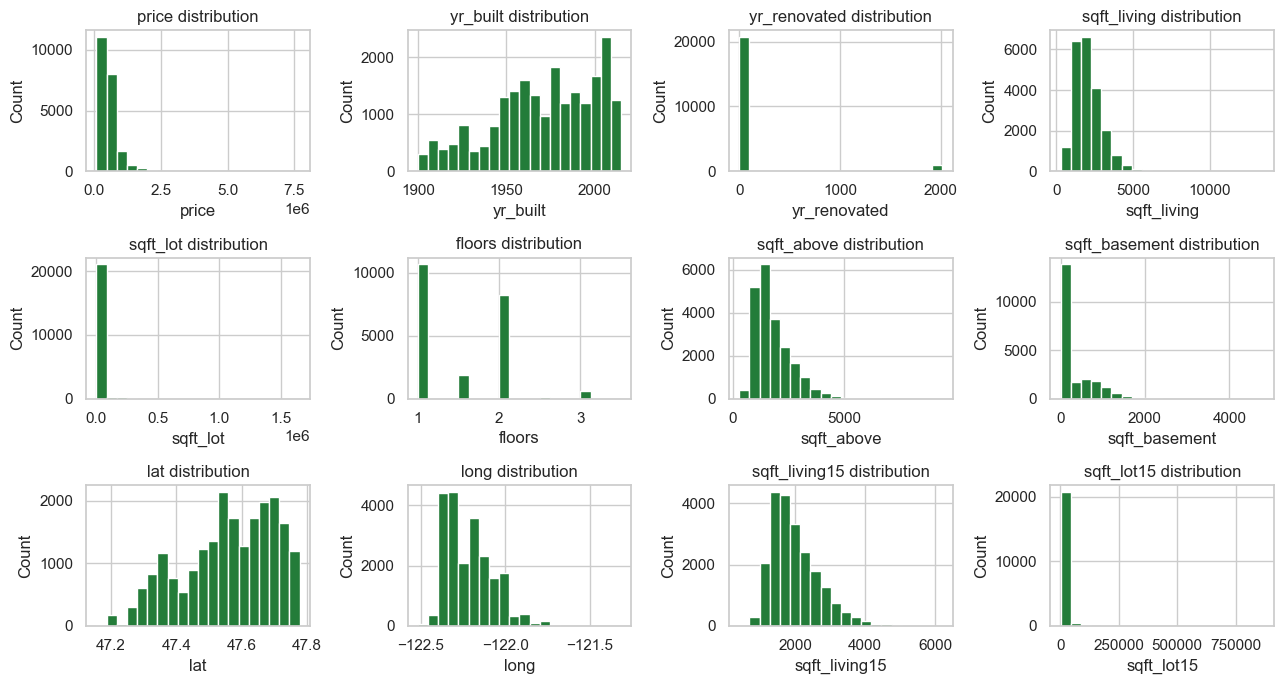

In [2848]:
mk_histplots(housing_clean,columns=col_cont,bins=30,figsize=(13,7),save='assets/test.png')

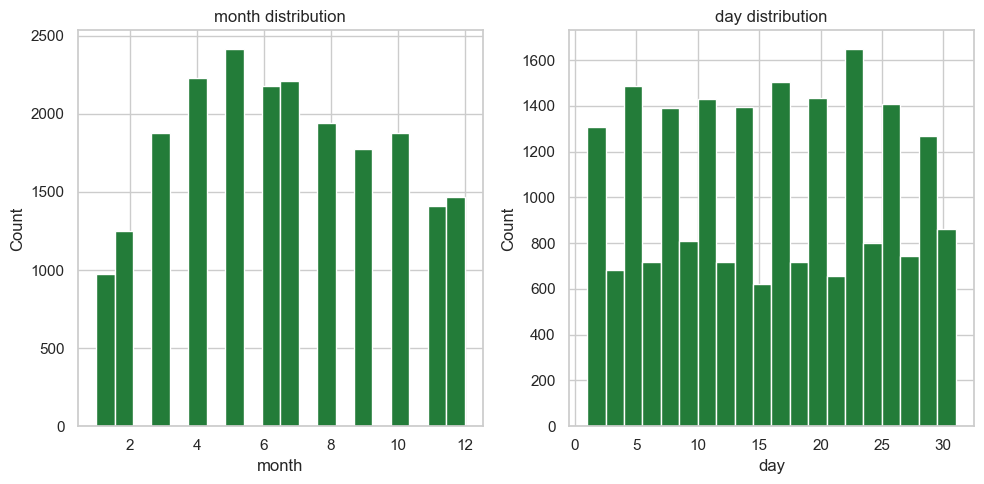

In [2849]:
mk_histplots(housing_clean,columns=['month','day'],bins=30,figsize=(10,5),save='assets/test.png')

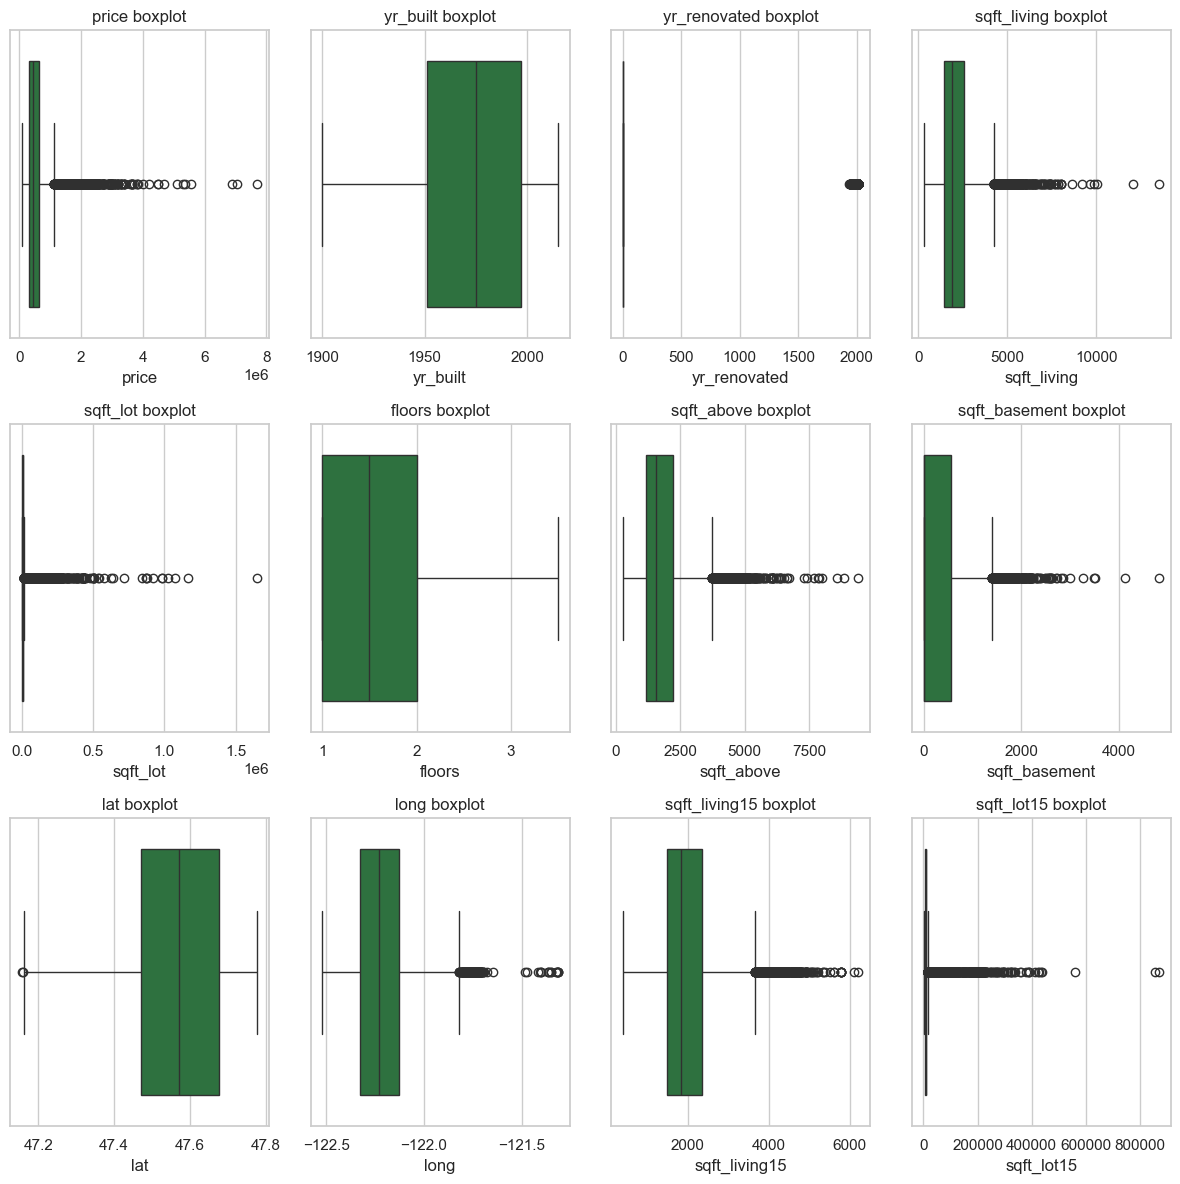

In [2850]:
mk_boxplots(housing_clean,columns=col_cont)

### Barplots for categorial variables

Note that some of them have a rather large number of categories.

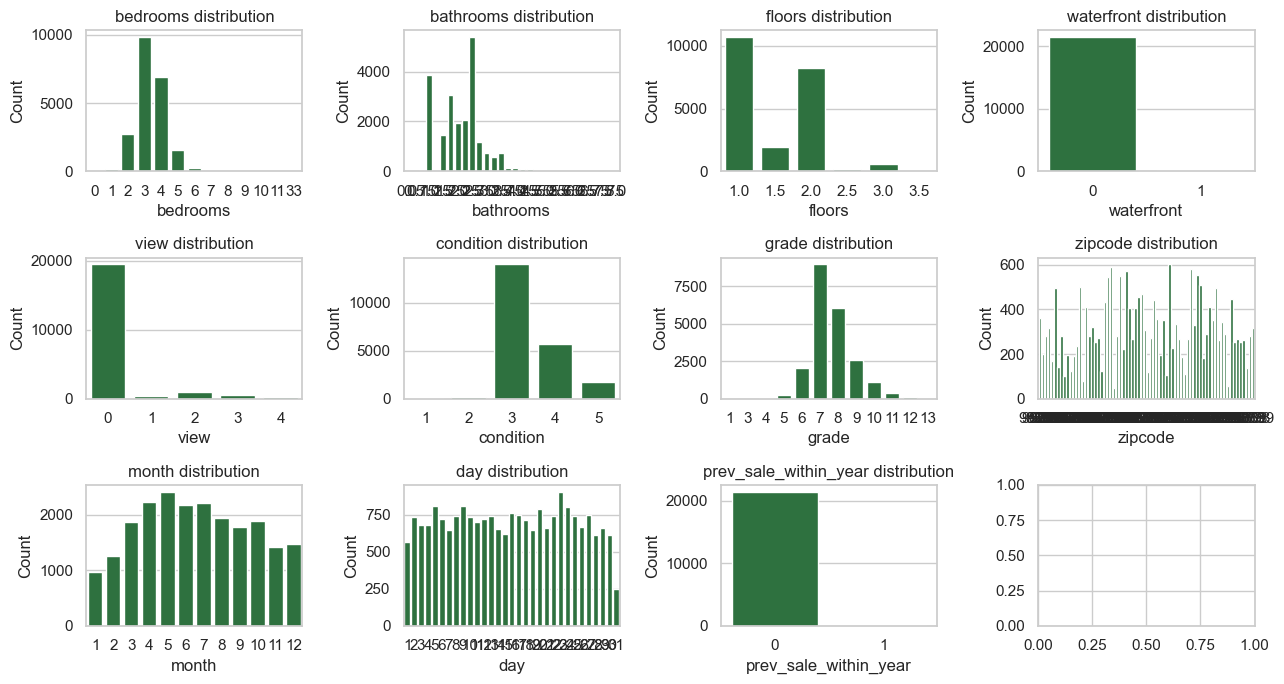

In [2851]:
mk_barplots(housing_clean,columns=col_cat,figsize=(13,7),sizex=4,sizey=3)

In [2852]:
housing.bathrooms.value_counts()

bathrooms
2.500000    5380
1.000000    3852
1.750000    3048
2.250000    2047
2.000000    1930
1.500000    1446
2.750000    1185
3.000000     753
3.500000     731
3.250000     589
3.750000     155
4.000000     136
4.500000     100
4.250000      79
0.750000      72
4.750000      23
5.000000      21
5.250000      13
0.000000      10
5.500000      10
1.250000       9
6.000000       6
0.500000       4
5.750000       4
6.750000       2
8.000000       2
6.500000       2
6.250000       2
7.750000       1
7.500000       1
Name: count, dtype: int64

Ok, the bathroom values are a bit odd. The description in the metadata is also a bit cryptic:

> It determines number of bathrooms in a bedroom of a house.

That sounds like its the number of bathrooms per bedroom, which might partly explain the floating point values, but then the prevalence of numbers over 1 is somewhat surprising. Maybe they mean the other way around, number of bedrooms per bathroom?

In [2853]:
pd.crosstab(housing['bedrooms'],housing['bathrooms'])

bathrooms,0.000000,0.500000,0.750000,1.000000,1.250000,1.500000,1.750000,2.000000,2.250000,2.500000,2.750000,3.000000,3.250000,3.500000,3.750000,4.000000,4.250000,4.500000,4.750000,5.000000,5.250000,5.500000,5.750000,6.000000,6.250000,6.500000,6.750000,7.500000,7.750000,8.000000
bedrooms,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,0,1,1,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,27,138,2,12,4,6,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,26,1558,3,294,304,216,118,197,20,13,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,16,1780,4,829,1870,1048,1082,2357,275,197,184,143,17,11,6,5,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,2,325,0,254,719,525,709,2502,639,326,254,395,78,58,38,32,7,7,5,5,1,0,0,0,0,0,0,0
5,0,0,0,43,0,48,134,110,116,287,214,163,129,169,44,48,25,35,11,7,4,4,2,4,2,1,1,0,0,0
6,0,0,0,6,0,6,16,24,15,29,31,45,12,17,13,11,8,23,3,6,3,0,0,1,0,1,0,0,1,1
7,0,0,0,1,0,2,0,0,3,2,3,3,1,5,2,5,2,3,2,0,0,1,1,0,0,0,1,0,0,1
8,0,0,0,0,0,0,0,0,0,1,3,2,1,1,1,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0


That can't be true either, otherwise there could be no non-0 values for bathroom while bedrooms is 0. So I'm not quite sure what the `bathroom` numbers mean, but they cannot be part of a direct ratio with `bedrooms` - either way there'd be division by 0.

I could round these numbers to reduce the range, but will leave it be for now.

PS: [This link](https://lifehacker.com/the-actual-difference-between-a-half-3-4-and-full-bat-1848773483) explains the terminology (thanks to Ana!). Quarter and three quarter bathrooms are indeed individual categories. I'll still leave considerations of binning for later, for now I'll keep this as a semi-continuous counting variable (building on the idea that "more bath is better").

Looking at these data, it might also be worth considering to bin the big values for the bedrooms column. Again, not doing this now, but possible option for additional data cleaning.

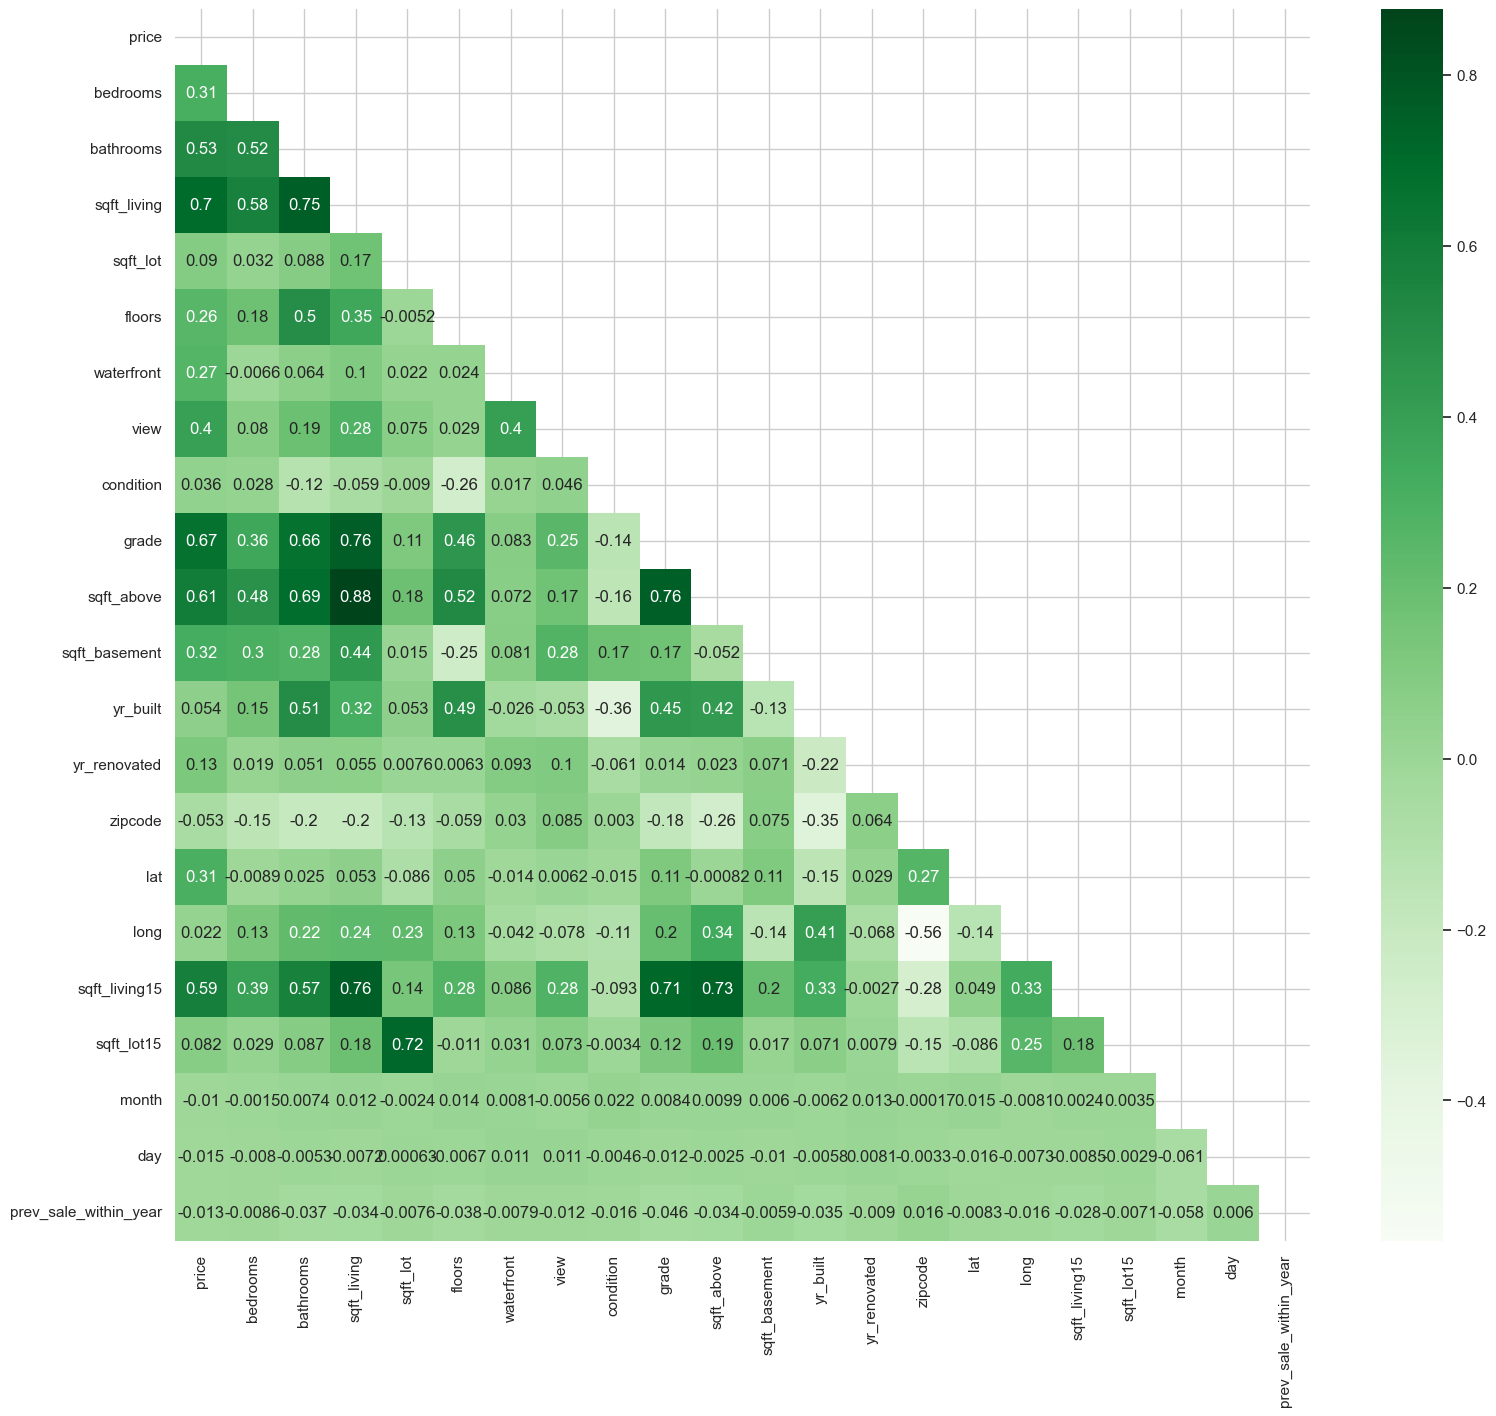

In [2854]:
# let's have a look at correlations

plot_corrmatrix(housing_clean,figsize=(15,13))

There are no concerning correlations at a first glance. There is also no correlation between zipcode and lat/long, which may also be due to the very different type of data representation (categorial vs. continuous).

# Modelling


## Train-test-split

A first pass 

In [2855]:
X = housing_clean.drop(columns='price')
y = housing_clean['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=6,test_size=.2)

## Helper functions

In [2856]:
def regression_report(model,X_train,X_test,y_train_obs,y_test_obs):
    """ Calculate and print a report of core metrics for a regression for training and test sets. 
    Returns metrics for test set for future use
    
    **arguments**:
    - model: model to report on
    - X_train: training set
    - X_test: the test set
    - y_train: observed target data for training set
    - y_test: observed target data for test set
    
    
    **return values**:
    - r2_adj_train: the adjusted r²-score for the training set
    - r²_adj_test: the adjusted r²-score for the test set
    - mae_train: the mean absolute errors for the training set
    - mae_test: the mean absolute errors for the test set 
    """
    
    # collecting and generating data for report
    n_feat = X_train.shape[1] 
    dat = {
        'training': {
        'obs': y_train_obs,
        'pred': model.predict(X_train),
        'n_obs': X_train.shape[0]
        },
        'test': {
        'obs': y_test_obs,
        'pred': model.predict(X_test),
        'n_obs': X_test.shape[0]
        }
    }

    # calculate and output metrics for training and test sets
    for subset in dat:
        tmp = dat[subset]
        # calculations
        r2_plain = metrics.r2_score(tmp['obs'],tmp['pred'])
        r2_adj = (1 - (1 - r2_plain) * ((tmp['n_obs'] - 1) / ( tmp['n_obs'] - n_feat - 1)))
        rmse = metrics.root_mean_squared_error(tmp['obs'],tmp['pred'])
        mae = metrics.mean_absolute_error(tmp['obs'],tmp['pred'])
        
        # output
        print(f'Metrics for {subset} set\n')
        print(f'r²-score', r2_plain)
        print('r² adjusted:', r2_adj)
        print('rMSE:', rmse)
        print('MAE:', mae)
        print('ratio MAE/max(target):', round(mae/pd.concat([y_train_obs,y_test_obs]).max(),4))
        print()
        
        if subset == 'training':
            r2_adj_train = r2_adj
            mae_train = mae
        elif subset == 'test':
            r2_adj_test = r2_adj
            mae_test = mae
        
    
    # return the statistics for the test set if desired for later comparison
    return r2_adj_train, r2_adj_test, mae_train, mae_test



def coeff_plot(model,columns,figsize=(9,6),save=False,transp=False):
    # Regression coefs
    coefs= pd.Series(np.abs(model.coef_), columns).sort_values()
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    
    plt.xlim()
    plt.tight_layout()


    coefs.plot(kind='bar', title='Coefficients',colormap='Dark2')
    plt.show()
    
    if save:
        plt.savefig(save,transparent=transp)
    

## Feature scaling

Not sure if I should apply scaling to all columns? I'll start with that and see how it goes...

In [2857]:
X_cont = ['sqft_living',
 'sqft_lot',
 'sqft_above',
 'lat',
 'long',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']

X_cat = list(filter(lambda x: x not in X_cont, list(X_train.columns)))

print(X_cat)

['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'month', 'day', 'prev_sale_within_year']


In [2858]:
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the transformer
coltrans = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X_cont),       # scale continuous columns
        ("cat", "passthrough", X_cat)            # leave categorical columns unchanged
    ]
)
coltrans.fit(X_train)

X_train_scaled = coltrans.transform(X_train)
X_test_scaled = coltrans.transform(X_test)


# Linear regression


Metrics for training set

r²-score 0.7041866341825214
r² adjusted: 0.7038268889495953
rMSE: 199818.2093064686
MAE: 125477.22544702151
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858719932255605
r² adjusted: 0.6843382363917396
rMSE: 205150.00900805517
MAE: 126752.16923863982
ratio MAE/max(target): 0.0165



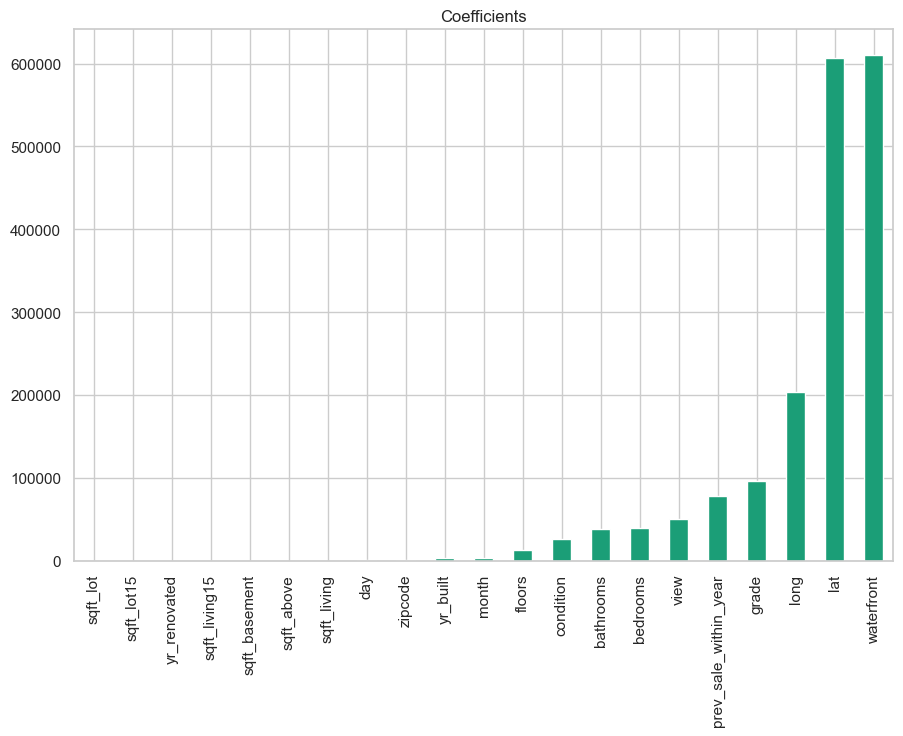

In [2859]:
# instantiate and fit linear regression model to scaled X and plain y training sets
lm = linear_model.LinearRegression().fit(X_train,y_train)

# setting up meta-info for result_lst
res = {'type': 'lm',
       'dropped': '',
       'scaled': False}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm,X_train,X_test,y_train,y_test)

coeff_plot(lm,X.columns)

# append results to result_lst
lm_result_lst.append(res)

Metrics for training set

r²-score 0.7041866341825216
r² adjusted: 0.7038268889495956
rMSE: 199818.2093064685
MAE: 125477.22544699493
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858719932255862
r² adjusted: 0.6843382363917656
rMSE: 205150.00900804676
MAE: 126752.16923861018
ratio MAE/max(target): 0.0165



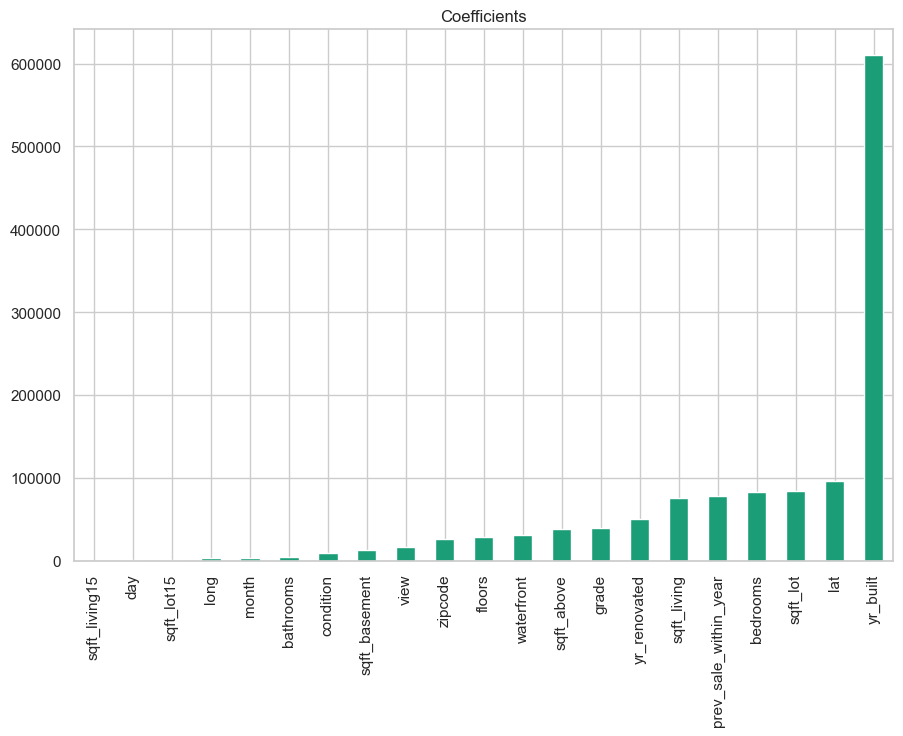

In [2860]:
# instantiate and fit linear regression model to scaled X and plain y training sets
lm = linear_model.LinearRegression().fit(X_train_scaled,y_train)

# setting up meta-info for result_lst
res = {'type': 'lm',
       'dropped': '',
       'scaled': True}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm,X_train_scaled,X_test_scaled,y_train,y_test)

coeff_plot(lm,X.columns)

# append results to result_lst
lm_result_lst.append(res)


Metrics for training set

r²-score 0.7041866318085761
r² adjusted: 0.703826886572763
rMSE: 199818.2101082537
MAE: 125477.22687670041
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858748286187807
r² adjusted: 0.6843410856290095
rMSE: 205149.0831398665
MAE: 126751.77199689788
ratio MAE/max(target): 0.0165



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e+13, tolerance: 2.334e+11
  model = cd_fast.enet_coordinate_descent(


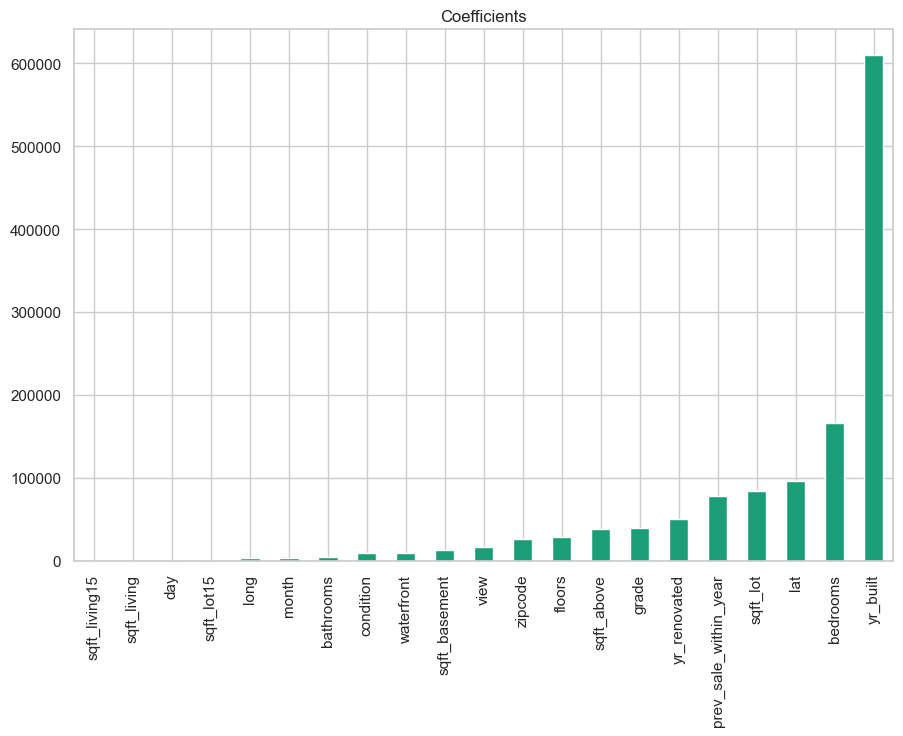

In [2861]:
alpha = 1
lm_lasso = linear_model.Lasso(alpha=alpha).fit(X_train_scaled,y_train)

res = {'type': 'lm-lasso',
       'metaparams': f'alpha: {alpha}',
       'dropped': '',
       'scaled': True}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm_lasso, X_train_scaled, X_test_scaled, y_train, y_test)
coeff_plot(lm_lasso,X.columns)

# append results to result_lst
lm_result_lst.append(res)

Metrics for training set

r²-score 0.6608327449644833
r² adjusted: 0.660420276099777
rMSE: 213960.2637013241
MAE: 124417.48581556017
ratio MAE/max(target): 0.0162

Metrics for test set

r²-score 0.655784161777522
r² adjusted: 0.6541034985357941
rMSE: 214750.22907986995
MAE: 124667.00557108919
ratio MAE/max(target): 0.0162



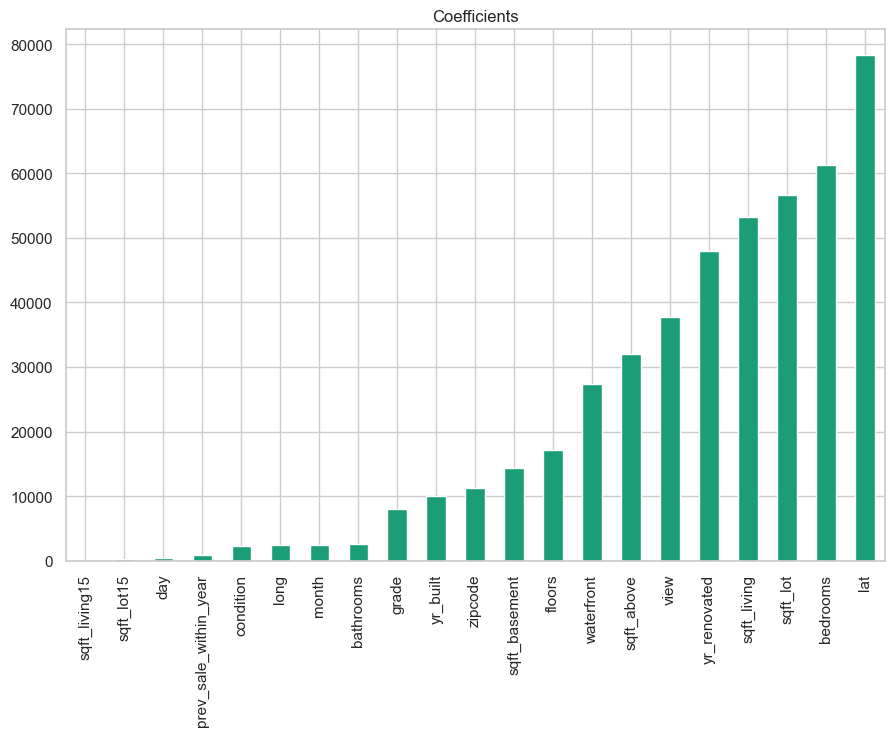

In [2862]:
alpha = 1
lm_elnet = linear_model.ElasticNet(alpha=alpha).fit(X_train_scaled,y_train)

res = {'type': 'lm-elnet',
       'metaparams': f'alpha: {alpha}',
       'dropped': '',
       'scaled': True}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm_elnet,X_train_scaled,X_test_scaled,y_train,y_test)
coeff_plot(lm_elnet,X.columns)

# append results to result_lst
lm_result_lst.append(res)

In [2863]:
pd.DataFrame(lm_result_lst)

,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams
0,lm,,False,0.703827,0.684338,125477.225447,126752.169239,NaN
1,lm,,True,0.703827,0.684338,125477.225447,126752.169239,NaN
2,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1
3,lm-elnet,,True,0.660420,0.654103,124417.485816,124667.005571,alpha: 1


The results so far are decent, but can probably be improved. It's interesting to note that the regularisation methods lasso and elastic net didn't improve model performance here, in fact elastic net resulted in a slight regression/decrease in the r² score (but at the same time also a slight decrease/improvement in the mean absolute errors).

In a next step, I'll implement some more data cleaning and check the results before turning to other learning algorithms.

# Additional data cleaning

The above models were trained on a very lightly cleaned dataset. I am now going to implement the following additional cleaning steps:

- drop `day` because it is not plausibly expected to have a significant impact and the initial modelling quite consistently assigned it a very low weight
- drop `zipcode`: lat/long already encode location (alternatively, transformation to categorial variable might be considered, but there are 70 distinct values and more knowledge about the structure would be needed for sensible binning)
- transform `yr_renovated` by binning and applying one hot encoding: this mainly aims to reduce the large influence of the high number of properties with a 0 value in this field 
- check whether binning would also make sense for `sqft_basement` which has a similar overweight of 0 values


In [2864]:
# dropping day and zipcode
housing_clean.drop(columns=['zipcode','day'],inplace=True)

## Binning

### `yr_renovated`

In [2865]:
# checking values for yr_renovated
housing_clean.yr_renovated.unique()
# binning!

array([   0, 1991, 2002, 2010, 1999, 1992, 2013, 1994, 1978, 2005, 2008,
       2003, 1984, 1954, 2014, 2011, 1974, 1983, 1945, 1990, 1988, 1957,
       1977, 1981, 1995, 2000, 1998, 1970, 1989, 2004, 1986, 2009, 2007,
       1987, 1973, 2006, 1985, 2001, 1980, 1971, 1979, 1997, 1950, 1969,
       1948, 2015, 1968, 2012, 1963, 1951, 1993, 1962, 1996, 1972, 1953,
       1955, 1982, 1956, 1940, 1976, 1946, 1975, 1958, 1964, 1959, 1960,
       1967, 1965, 1934, 1944])

In [2866]:
housing_transformed = housing_clean.copy()

In [2867]:

# binning and preparing named labels
bins = [0, 1900, 1990, 2000, 2010, 2015]
labels = ['never', 'pre-90s', '90s', '00s', '10s']
housing_transformed['renovation'] = pd.cut(housing_transformed['yr_renovated'],
       bins=bins,labels=labels,    
       right=True,  # default, means (1900, 1980]
        include_lowest=True  # include 0 in first bin)
)

# add integer label encoding to housing_clean
labels_int = list(range(len(labels)))
housing_clean['renovation_cat'] = pd.cut(housing_transformed['yr_renovated'],
       bins=bins,labels=labels_int,    
       right=True,  # default, means (1900, 1980]
        include_lowest=True  # include 0 in first bin)
).astype(int)
housing_clean.drop(columns='yr_renovated',inplace=True)

In [2868]:
# overview of distribution
housing_transformed.groupby('renovation',observed=True).size()

renovation
never      20699
pre-90s      299
90s          192
00s          255
10s          168
dtype: int64

In [2869]:
housing_transformed = pd.concat(
    [housing_transformed,
     pd.get_dummies(housing_transformed['renovation'],prefix='renov').astype(int)],axis=1).drop(columns=['yr_renovated','renovation'])

In [2870]:
housing_transformed.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,month,prev_sale_within_year,renov_never,renov_pre-90s,renov_90s,renov_00s,renov_10s
21608,360000.000000,3,2.500000,1530,1131,3.000000,0,0,3,8,1530,0,2009,47.699300,-122.346000,1530,1509,5,0,1,0,0,0,0
21609,400000.000000,4,2.500000,2310,5813,2.000000,0,0,3,8,2310,0,2014,47.510700,-122.362000,1830,7200,2,0,1,0,0,0,0
21610,402101.000000,2,0.750000,1020,1350,2.000000,0,0,3,7,1020,0,2009,47.594400,-122.299000,1020,2007,6,0,1,0,0,0,0
21611,400000.000000,3,2.500000,1600,2388,2.000000,0,0,3,8,1600,0,2004,47.534500,-122.069000,1410,1287,1,0,1,0,0,0,0
21612,325000.000000,2,0.750000,1020,1076,2.000000,0,0,3,7,1020,0,2008,47.594100,-122.299000,1020,1357,10,0,1,0,0,0,0


### `yr_built`

Binning might also make sense for yr_built.

In [2871]:
sorted(housing_transformed.yr_built.unique())


[np.int64(1900),
 np.int64(1901),
 np.int64(1902),
 np.int64(1903),
 np.int64(1904),
 np.int64(1905),
 np.int64(1906),
 np.int64(1907),
 np.int64(1908),
 np.int64(1909),
 np.int64(1910),
 np.int64(1911),
 np.int64(1912),
 np.int64(1913),
 np.int64(1914),
 np.int64(1915),
 np.int64(1916),
 np.int64(1917),
 np.int64(1918),
 np.int64(1919),
 np.int64(1920),
 np.int64(1921),
 np.int64(1922),
 np.int64(1923),
 np.int64(1924),
 np.int64(1925),
 np.int64(1926),
 np.int64(1927),
 np.int64(1928),
 np.int64(1929),
 np.int64(1930),
 np.int64(1931),
 np.int64(1932),
 np.int64(1933),
 np.int64(1934),
 np.int64(1935),
 np.int64(1936),
 np.int64(1937),
 np.int64(1938),
 np.int64(1939),
 np.int64(1940),
 np.int64(1941),
 np.int64(1942),
 np.int64(1943),
 np.int64(1944),
 np.int64(1945),
 np.int64(1946),
 np.int64(1947),
 np.int64(1948),
 np.int64(1949),
 np.int64(1950),
 np.int64(1951),
 np.int64(1952),
 np.int64(1953),
 np.int64(1954),
 np.int64(1955),
 np.int64(1956),
 np.int64(1957),
 np.int64(1958

In [2872]:

# binning
bins = [1900, 1930, 1960, 1980, 2000, 2010,2020]
labels = ['early 20th ct', '30s-50s', '60s-70s', '80s-90s','2000s','after 2010']
housing_transformed['built'] = pd.cut(housing_transformed['yr_built'],
       bins=bins,labels=labels,    
       right=True,  # default
        include_lowest=True  # include 1900 in first bin)
)

# add to housing_clean
labels_int = range(len(labels))
housing_clean['built_cat'] = pd.cut(housing_transformed['yr_built'],
       bins=bins,labels=labels_int,    
       right=True,  # default
        include_lowest=True  # include 1900 in first bin)
).astype(int)
housing_clean.drop(columns='yr_built',inplace=True)

In [2873]:
# overview of distribution
housing_transformed.built.value_counts()

built
60s-70s          4937
30s-50s          4904
80s-90s          4498
2000s            3443
early 20th ct    2733
after 2010       1098
Name: count, dtype: int64

In [2874]:
housing_transformed = pd.concat(
    [housing_transformed,
     pd.get_dummies(housing_transformed['built'],prefix='built').astype(int)],axis=1).drop(columns=['yr_built','built'])

In [2875]:
housing_transformed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,month,prev_sale_within_year,renov_never,renov_pre-90s,renov_90s,renov_00s,renov_10s,built_early 20th ct,built_30s-50s,built_60s-70s,built_80s-90s,built_2000s,built_after 2010
0,221900.000000,3,1.000000,1180,5650,1.000000,0,0,3,7,1180,0,47.511200,-122.257000,1340,5650,10,0,1,0,0,0,0,0,1,0,0,0,0
1,538000.000000,3,2.250000,2570,7242,2.000000,0,0,3,7,2170,400,47.721000,-122.319000,1690,7639,12,0,0,0,1,0,0,0,1,0,0,0,0
2,180000.000000,2,1.000000,770,10000,1.000000,0,0,3,6,770,0,47.737900,-122.233000,2720,8062,2,0,1,0,0,0,0,0,1,0,0,0,0
3,604000.000000,4,3.000000,1960,5000,1.000000,0,0,5,7,1050,910,47.520800,-122.393000,1360,5000,12,0,1,0,0,0,0,0,0,1,0,0,0
4,510000.000000,3,2.000000,1680,8080,1.000000,0,0,3,8,1680,0,47.616800,-122.045000,1800,7503,2,0,1,0,0,0,0,0,0,0,1,0,0


### `sqft_lot`, `sqft_lot15`, `sqft_basement`

Let's check the distribution of those categories again, since they also have fairly large 0 amounts of 0 values.

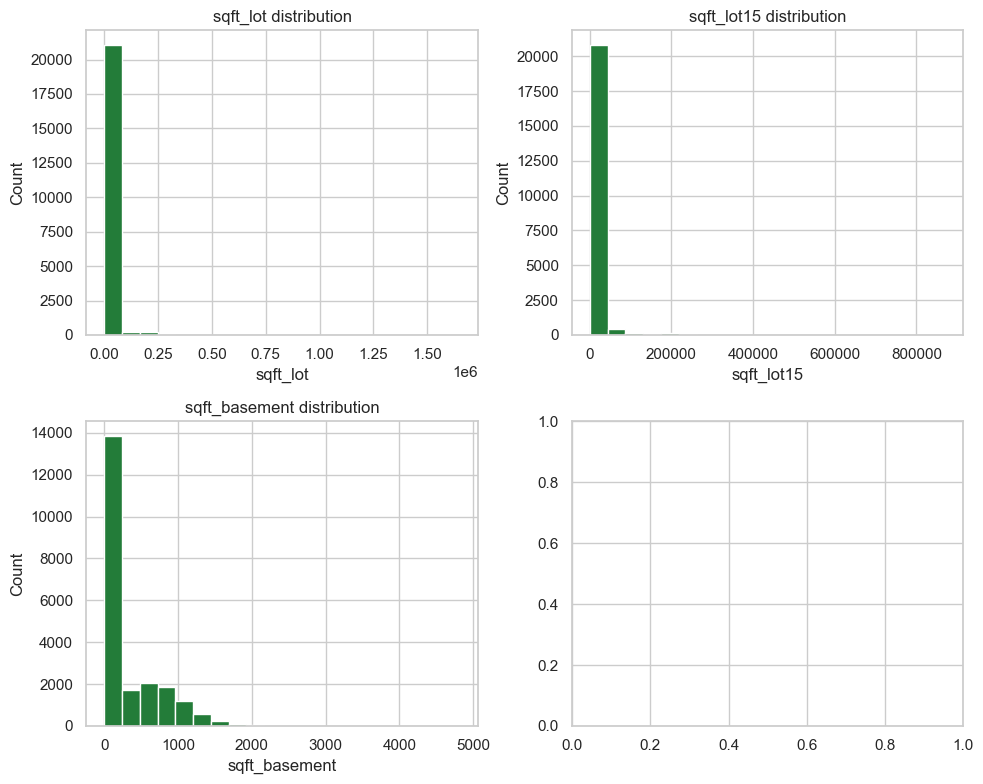

In [2876]:
mk_histplots(housing_transformed,columns=['sqft_lot','sqft_lot15','sqft_basement'],figsize=(10,8))

Let's bin them too!

In [2877]:
housing_transformed.sqft_basement.describe()

count   21613.000000
mean      291.509045
std       442.575043
min         0.000000
25%         0.000000
50%         0.000000
75%       560.000000
max      4820.000000
Name: sqft_basement, dtype: float64

In [2878]:
# categorising sqft_basement

# ensure value 0 is categorised as none 
housing_transformed.loc[housing_transformed['sqft_basement'] == 0, 'basement_cat'] = 'none'

# categorise remaining data into three bins based on quantiles
nonzero_bins,bin_edges = pd.qcut(
    housing_transformed.loc[housing_transformed['sqft_basement'] > 0, 'sqft_basement'],
    q=3,
    labels=['small', 'medium', 'large'],
    retbins=True
)

print(bin_edges)

housing_transformed.loc[housing_transformed['sqft_basement'] > 0, 'basement_cat'] = nonzero_bins

# add categories to housing_clean
labels_int = range(len(labels))
housing_clean['basement_cat'] = housing_transformed['basement_cat']
replacedict = {
    'none': 0,
    'small': 1,
    'medium': 2,
    'large': 3
}
# Convert to categorical with an explicit order and get integer codes
housing_clean['basement_cat'] = housing_clean['basement_cat'].replace(replacedict)
housing_clean.drop(columns='sqft_basement',inplace=True)


[  10.  530.  870. 4820.]


/tmp/ipykernel_11066/1426051468.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  housing_clean['basement_cat'] = housing_clean['basement_cat'].replace(replacedict)


In [2879]:
# overview of distribution
housing_transformed['basement_cat'].value_counts()

basement_cat
none      13126
small      2904
large      2826
medium     2757
Name: count, dtype: int64

In [2880]:
housing_transformed = pd.concat(
    [housing_transformed,
     pd.get_dummies(housing_transformed['basement_cat'],prefix='bsmnt').
                                 astype(int)],axis=1).drop(columns=['sqft_basement','basement_cat'])

In [2881]:
housing_transformed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,lat,long,sqft_living15,sqft_lot15,month,prev_sale_within_year,renov_never,renov_pre-90s,renov_90s,renov_00s,renov_10s,built_early 20th ct,built_30s-50s,built_60s-70s,built_80s-90s,built_2000s,built_after 2010,bsmnt_large,bsmnt_medium,bsmnt_none,bsmnt_small
0,221900.000000,3,1.000000,1180,5650,1.000000,0,0,3,7,1180,47.511200,-122.257000,1340,5650,10,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,538000.000000,3,2.250000,2570,7242,2.000000,0,0,3,7,2170,47.721000,-122.319000,1690,7639,12,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,180000.000000,2,1.000000,770,10000,1.000000,0,0,3,6,770,47.737900,-122.233000,2720,8062,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,604000.000000,4,3.000000,1960,5000,1.000000,0,0,5,7,1050,47.520800,-122.393000,1360,5000,12,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,510000.000000,3,2.000000,1680,8080,1.000000,0,0,3,8,1680,47.616800,-122.045000,1800,7503,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## Visualising categorial data

In [2882]:
labels_cat = ['bedrooms', 'bathrooms','floors',
       'waterfront', 'view', 'condition', 'grade', 'month', 'prev_sale_within_year',
       'renovation_cat', 'built_cat', 'basement_cat']

labels_cont = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']

In [2883]:
col_cat_new = list(filter(lambda x: '_cat' in x,housing_clean.columns))
col_cat_new

['renovation_cat', 'built_cat', 'basement_cat']

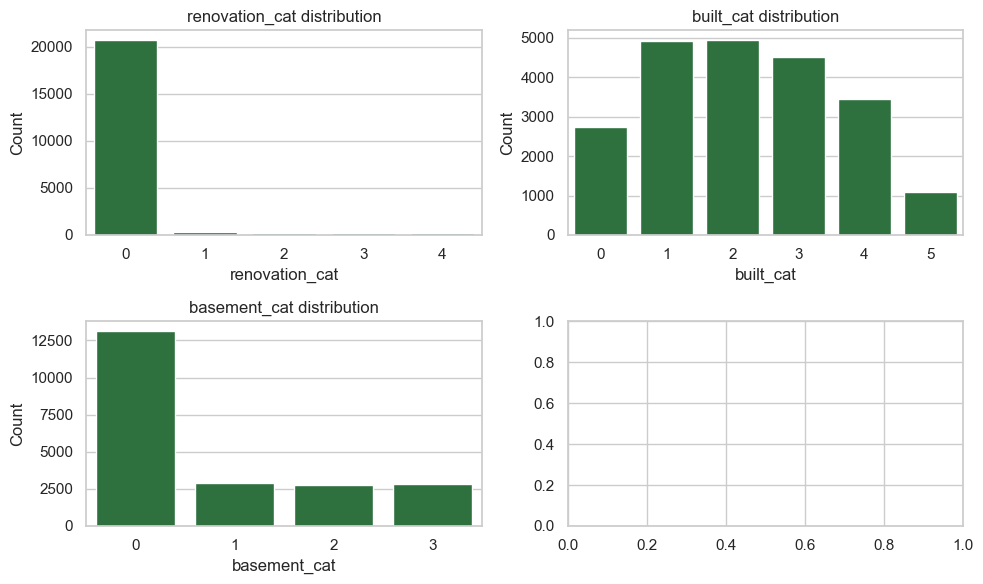

In [2884]:
mk_barplots(housing_clean,columns=col_cat_new,figsize=(10,6))

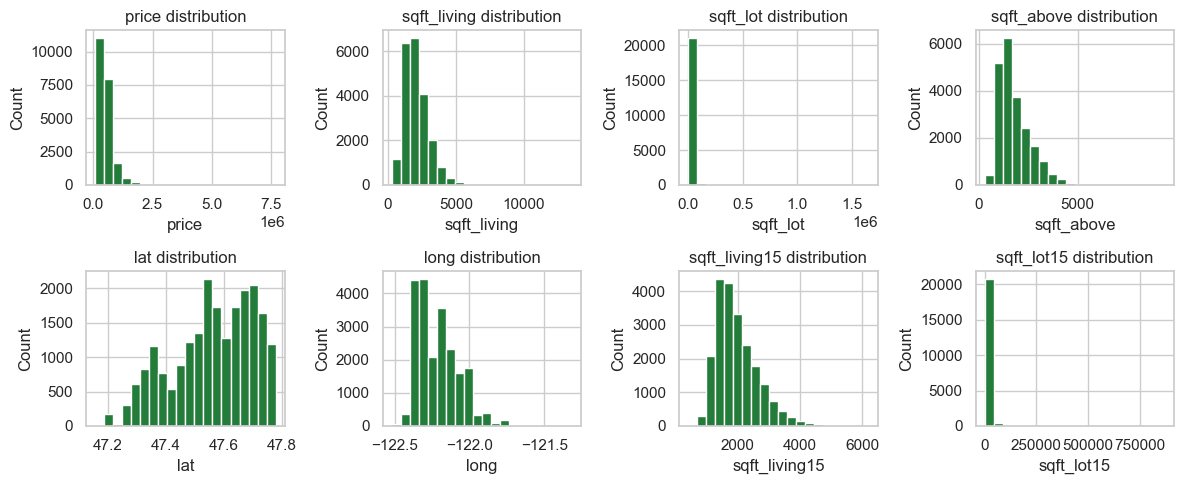

In [2885]:
mk_histplots(housing_clean,columns=labels_cont,sizex=4,sizey=2,figsize=(12,5),save='assets/histplots_clean.png',transp=True)

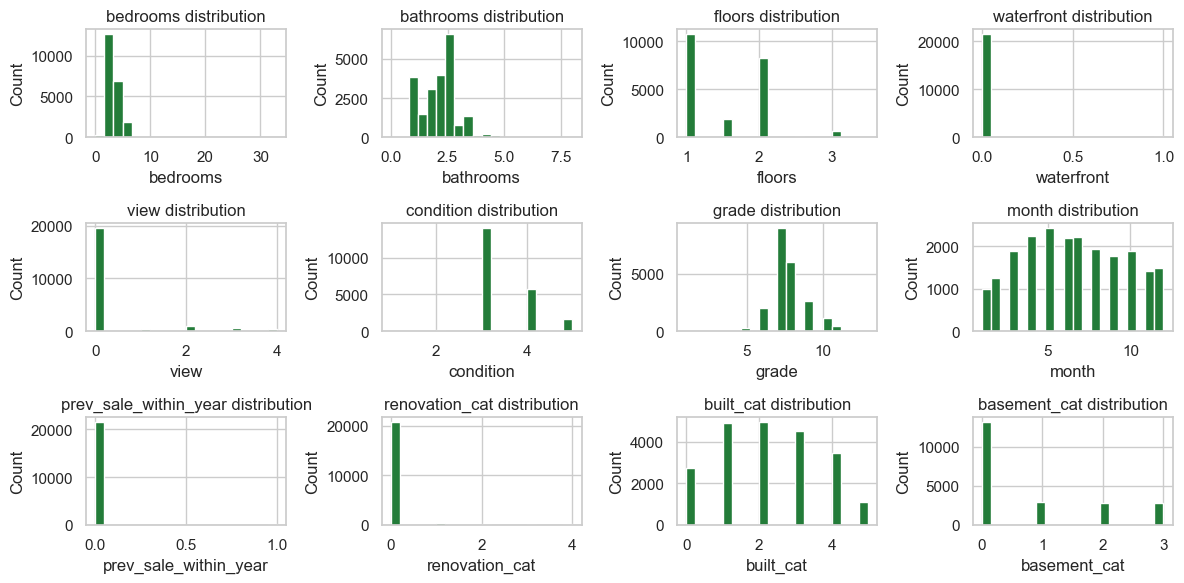

In [2886]:
mk_histplots(housing_clean,columns=labels_cat,figsize=(12,6),save='assets/barplots_clean.png',transp=True)

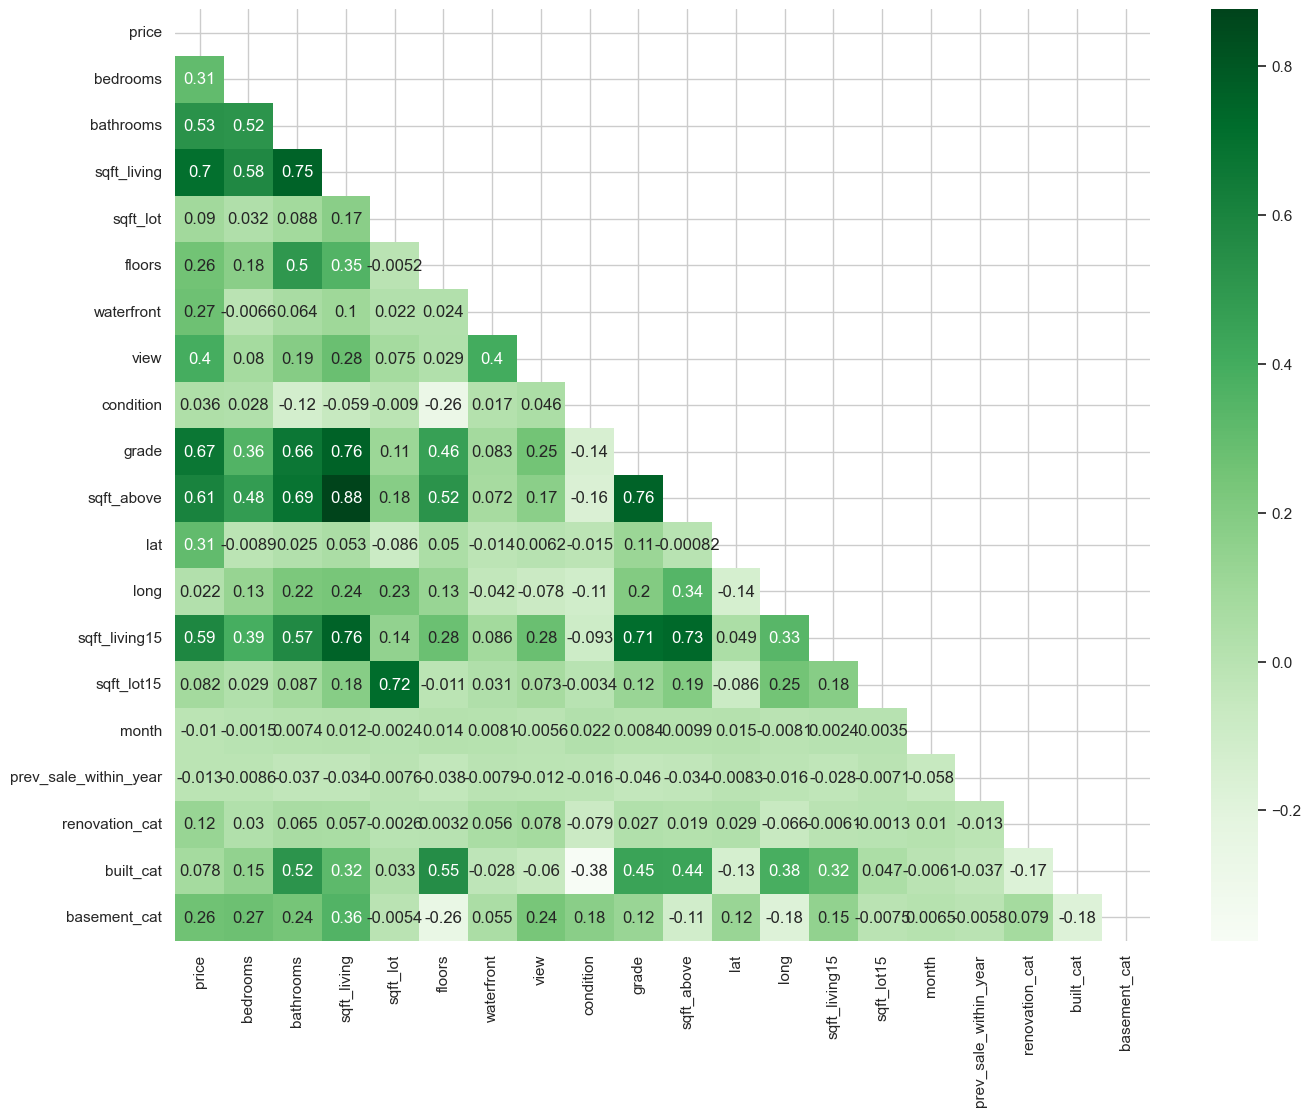

In [2887]:
plot_corrmatrix(housing_clean,figsize=(13,10),save='assets/corrmatrix_clean.png',transp=True)

# Testing the linear models on cleaner datasets

In [2888]:
housing_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'prev_sale_within_year',
       'renovation_cat', 'built_cat', 'basement_cat'],
      dtype='object')

In [2889]:
# splitting
X_OHE = housing_transformed.drop(columns='price')
X_labels = housing_clean.drop(columns='price')
y = housing_transformed['price']

X_OHE_train,X_OHE_test,y_train,y_test = train_test_split(X_OHE,y,random_state=6,test_size=.2)
X_labels_train,X_labels_test,y_train,y_test = train_test_split(X_labels,y,random_state=6,test_size=.2)

In [2890]:
X_OHE.columns


Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'prev_sale_within_year',
       'renov_never', 'renov_pre-90s', 'renov_90s', 'renov_00s', 'renov_10s',
       'built_early 20th ct', 'built_30s-50s', 'built_60s-70s',
       'built_80s-90s', 'built_2000s', 'built_after 2010', 'bsmnt_large',
       'bsmnt_medium', 'bsmnt_none', 'bsmnt_small'],
      dtype='object')

In [2891]:
X_cont = ['sqft_living', 'sqft_lot',
          'sqft_above', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']

# have this here just in case, although the lists for the co
# X_labels_cont = ['sqft_living', 'sqft_lot',
#           'sqft_above', 'lat', 'long',
#        'sqft_living15', 'sqft_lot15']

X_OHE_cat = list(filter(lambda x: x not in X_cont, list(X_OHE.columns)))

X_labels_cat = list(filter(lambda x: x not in X_cont, list(X_labels.columns)))

# scaling

# Define the transformer
coltrans_OHE = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X_cont),       # scale continuous columns
        ("cat", "passthrough", X_OHE_cat)            # leave categorical columns unchanged
    ]
)
coltrans_OHE.fit(X_OHE_train)

X_OHE_train_scaled = coltrans_OHE.transform(X_OHE_train)
X_OHE_test_scaled = coltrans_OHE.transform(X_OHE_test)


# Define the transformer for labels
coltrans_labels = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X_cont),       # scale continuous columns
        ("cat", "passthrough", X_labels_cat)            # leave categorical columns unchanged
    ]
)
coltrans_labels.fit(X_labels_train)

X_labels_train_scaled = coltrans_labels.transform(X_labels_train)
X_labels_test_scaled = coltrans_labels.transform(X_labels_test)



Metrics for training set

r²-score 0.7060376040608245
r² adjusted: 0.7055095686990147
rMSE: 199192.07486378815
MAE: 125160.95931132553
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.683385730926916
r² adjusted: 0.6810983754523726
rMSE: 205960.27018549963
MAE: 126144.83814194206
ratio MAE/max(target): 0.0164



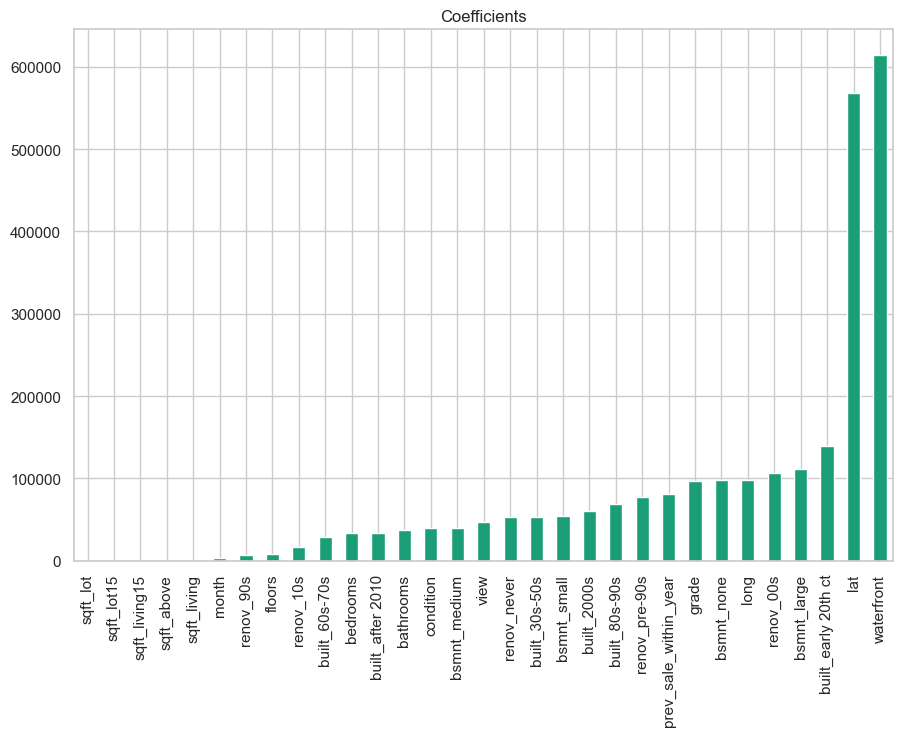

In [2892]:
# NO SCALING
# OHE

# instantiate and fit linear regression model to scaled X and plain y training sets
lm = linear_model.LinearRegression().fit(X_OHE_train,y_train)

# setting up meta-info for result_lst
res = {'type': 'lm',
       'scaled': False,
       'transform': 'OHE',
       'dropped': 'day,zipcode,yr_renovated,yr_built',
       'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm,X_OHE_train,X_OHE_test,y_train,y_test)

coeff_plot(lm,X_OHE.columns)

# append results to result_lst
lm_result_lst.append(res)

Metrics for training set

r²-score 0.696886830499823
r² adjusted: 0.6965533533590874
rMSE: 202268.64684201044
MAE: 127513.56137917785
ratio MAE/max(target): 0.0166

Metrics for test set

r²-score 0.6735816955702663
r² adjusted: 0.6721403876957217
rMSE: 209124.76374376513
MAE: 127800.2736946638
ratio MAE/max(target): 0.0166



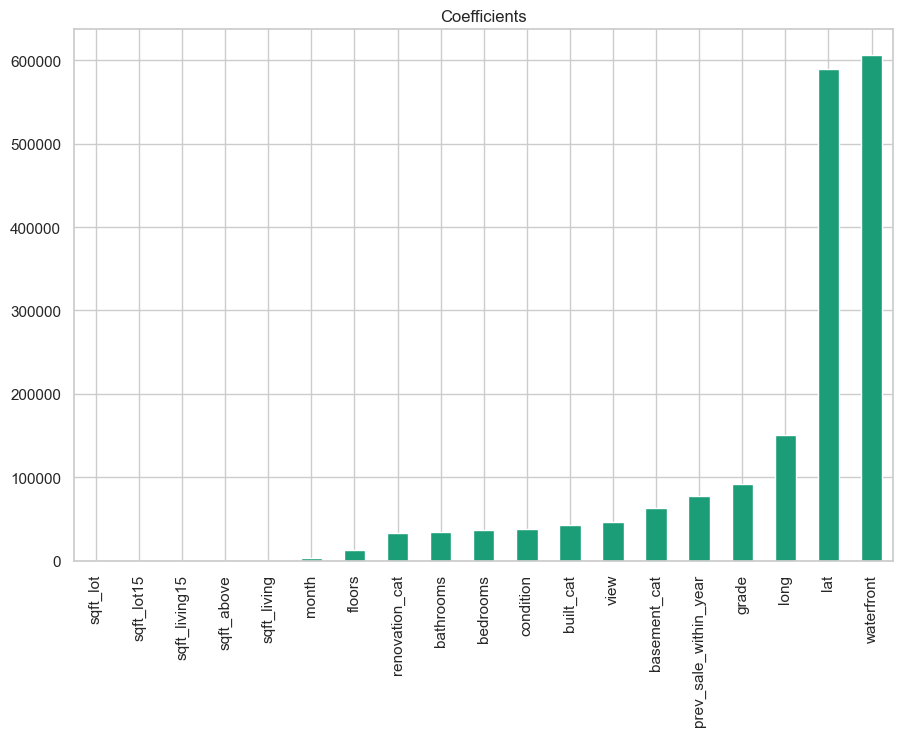

In [2893]:
# NO SCALING
# label cats

# instantiate and fit linear regression model to scaled X and plain y training sets
lm = linear_model.LinearRegression().fit(X_labels_train,y_train)

# setting up meta-info for result_lst
res = {'type': 'lm',
       'scaled': False,
       'transform': 'labels',
       'dropped': 'day,zipcode,yr_renovated,yr_built',
       'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm,X_labels_train,X_labels_test,y_train,y_test)

coeff_plot(lm,X_labels.columns)

# append results to result_lst
lm_result_lst.append(res)

Metrics for training set

r²-score 0.7060376040608245
r² adjusted: 0.7055095686990147
rMSE: 199192.07486378815
MAE: 125160.95931129508
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6833857309269203
r² adjusted: 0.681098375452377
rMSE: 205960.27018549823
MAE: 126144.83814191041
ratio MAE/max(target): 0.0164



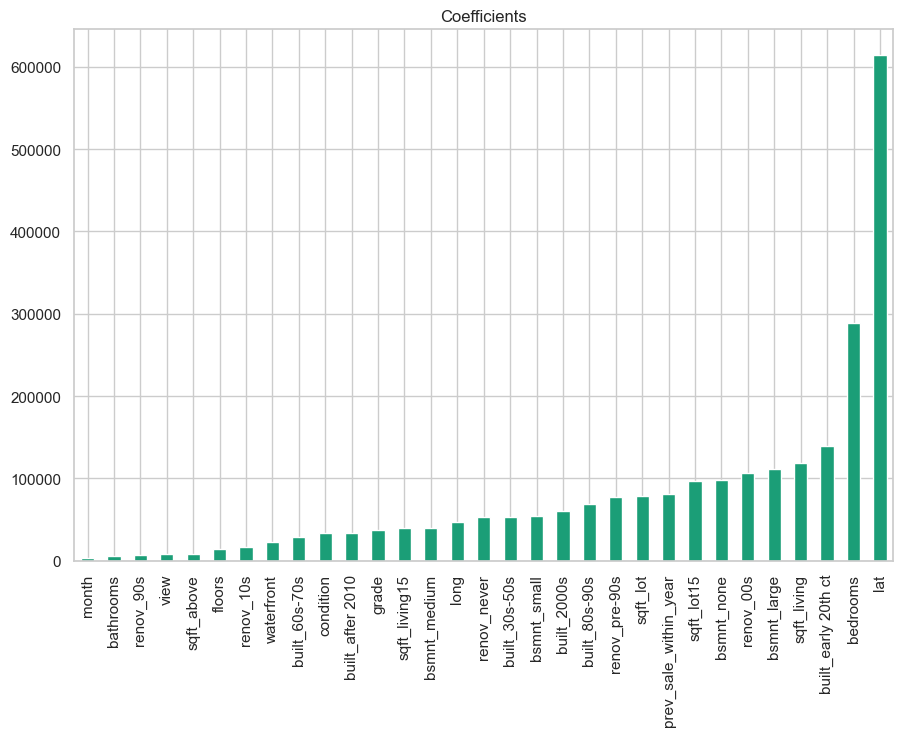

In [2894]:
# SCALING for continuous
# One-hot encoding

# instantiate and fit linear regression model to scaled X and plain y training sets
lm = linear_model.LinearRegression().fit(X_OHE_train_scaled,y_train)

# setting up meta-info for result_lst
res = {'type': 'lm',
       'scaled': True,
       'transform': 'OHE',
       'dropped': 'day,zipcode,yr_renovated,yr_built',
       'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm,X_OHE_train_scaled,X_OHE_test_scaled,y_train,y_test)

coeff_plot(lm,X_OHE.columns)

# append results to result_lst
lm_result_lst.append(res)

Metrics for training set

r²-score 0.6968868304998223
r² adjusted: 0.6965533533590866
rMSE: 202268.6468420107
MAE: 127513.56137917744
ratio MAE/max(target): 0.0166

Metrics for test set

r²-score 0.6735816955702709
r² adjusted: 0.6721403876957264
rMSE: 209124.76374376364
MAE: 127800.27369466293
ratio MAE/max(target): 0.0166



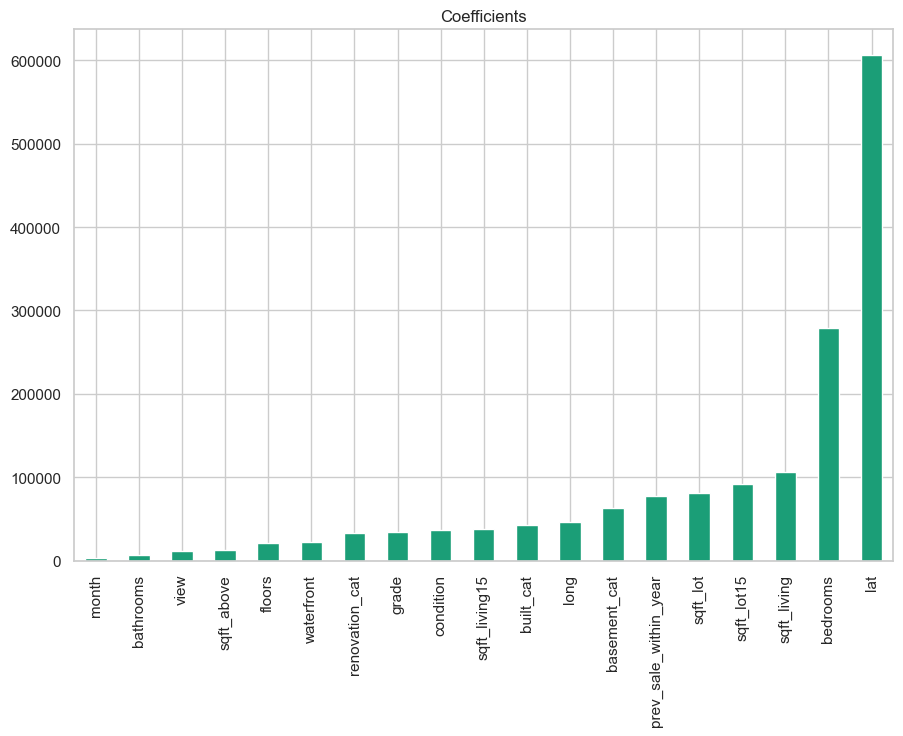

In [2895]:
# SCALING for continuous
# label cats

# instantiate and fit linear regression model to scaled X and plain y training sets
lm = linear_model.LinearRegression().fit(X_labels_train_scaled,y_train)

# setting up meta-info for result_lst
res = {'type': 'lm',
       'scaled': True,
       'transform': 'labels',
       'dropped': 'day,zipcode,yr_renovated,yr_built',
       'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)

coeff_plot(lm,X_labels.columns)

# append results to result_lst
lm_result_lst.append(res)

In [2896]:
pd.DataFrame(lm_result_lst)

,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
0,lm,,False,0.703827,0.684338,125477.225447,126752.169239,NaN,NaN,NaN
1,lm,,True,0.703827,0.684338,125477.225447,126752.169239,NaN,NaN,NaN
2,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,NaN
3,lm-elnet,,True,0.660420,0.654103,124417.485816,124667.005571,alpha: 1,NaN,NaN
4,lm,"day,zipcode,yr_renovated,yr_built",False,0.705510,0.681098,125160.959311,126144.838142,NaN,OHE,"renovation_cat,built_cat,basement_cat"
5,lm,"day,zipcode,yr_renovated,yr_built",False,0.696553,0.672140,127513.561379,127800.273695,NaN,labels,"renovation_cat,built_cat,basement_cat"
6,lm,"day,zipcode,yr_renovated,yr_built",True,0.705510,0.681098,125160.959311,126144.838142,NaN,OHE,"renovation_cat,built_cat,basement_cat"
7,lm,"day,zipcode,yr_renovated,yr_built",True,0.696553,0.672140,127513.561379,127800.273695,NaN,labels,"renovation_cat,built_cat,basement_cat"


For the linear models, scaling of continuous variables does not seem to have an impact. One-Hot-Encoding seems to yield slightly better results than labelled encoding.

Metrics for training set

r²-score 0.7041866339688672
r² adjusted: 0.7038268887356813
rMSE: 199818.20937862893
MAE: 125477.22575301451
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858728443495093
r² adjusted: 0.684339091671374
rMSE: 205149.73108281405
MAE: 126752.05006609671
ratio MAE/max(target): 0.0165



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e+13, tolerance: 2.334e+11
  model = cd_fast.enet_coordinate_descent(


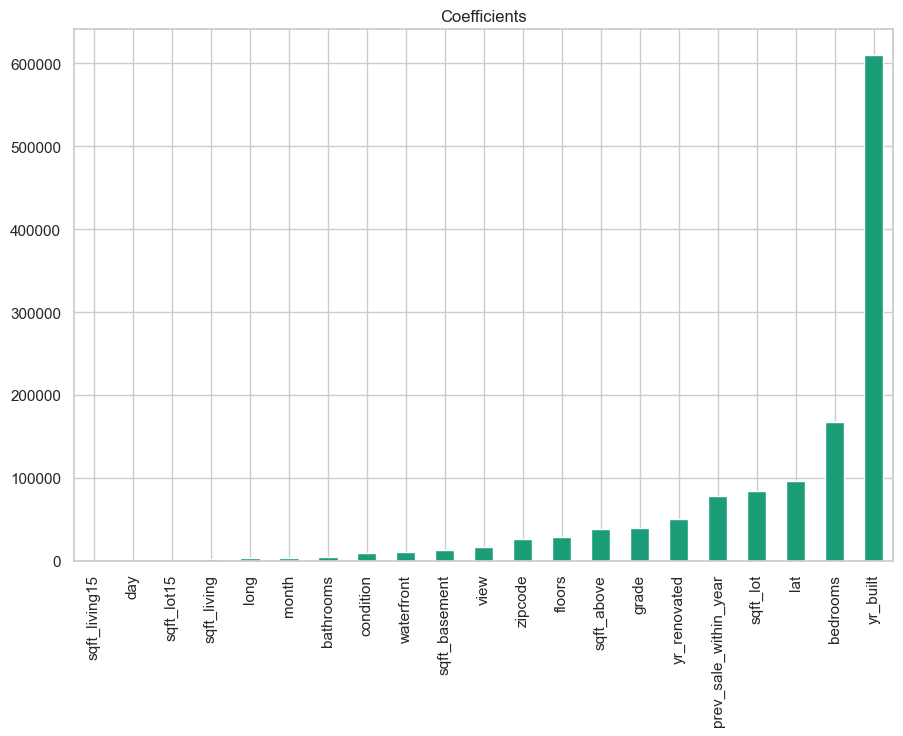

Metrics for training set

r²-score 0.7041866335890351
r² adjusted: 0.7038268883553873
rMSE: 199818.20950691486
MAE: 125477.22595702812
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858734115245216
r² adjusted: 0.6843396616156667
rMSE: 205149.54587779168
MAE: 126751.97061775476
ratio MAE/max(target): 0.0165



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e+13, tolerance: 2.334e+11
  model = cd_fast.enet_coordinate_descent(


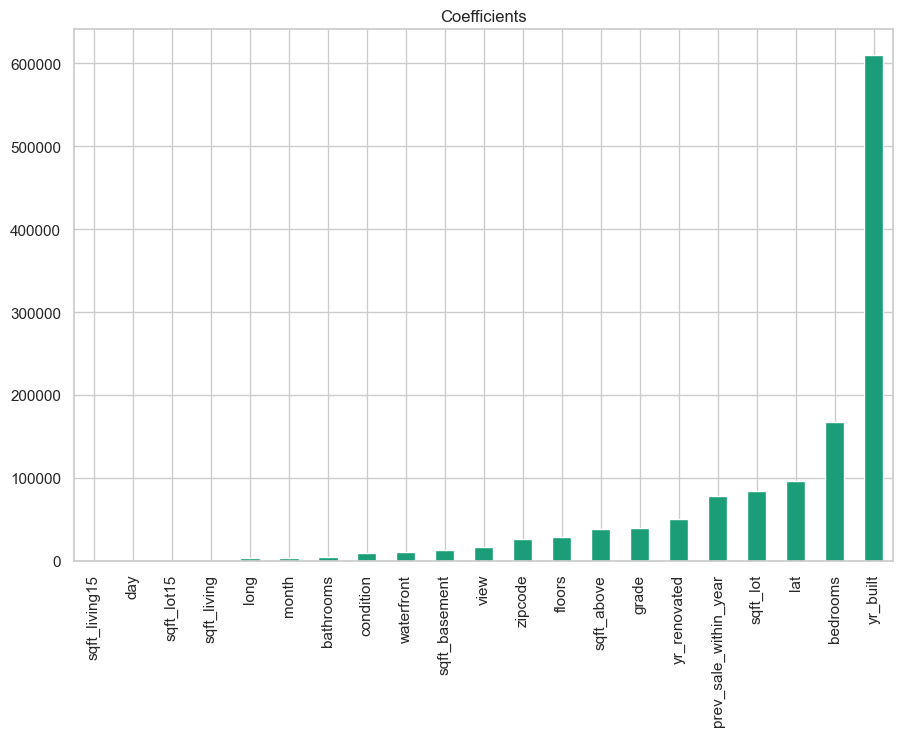

Metrics for training set

r²-score 0.7041866330192885
r² adjusted: 0.7038268877849478
rMSE: 199818.20969934316
MAE: 125477.22624973148
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858739785067869
r² adjusted: 0.6843402313662713
rMSE: 205149.36073554173
MAE: 126751.89116941197
ratio MAE/max(target): 0.0165



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e+13, tolerance: 2.334e+11
  model = cd_fast.enet_coordinate_descent(


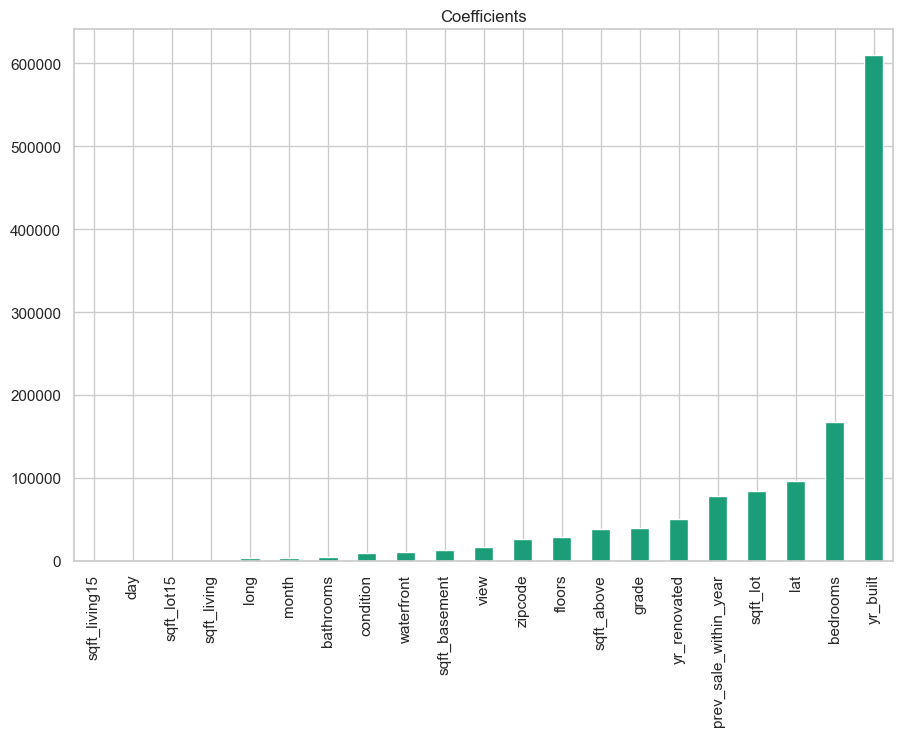

Metrics for training set

r²-score 0.7041866318085761
r² adjusted: 0.703826886572763
rMSE: 199818.2101082537
MAE: 125477.22687670041
ratio MAE/max(target): 0.0163

Metrics for test set

r²-score 0.6858748286187807
r² adjusted: 0.6843410856290095
rMSE: 205149.0831398665
MAE: 126751.77199689788
ratio MAE/max(target): 0.0165



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e+13, tolerance: 2.334e+11
  model = cd_fast.enet_coordinate_descent(


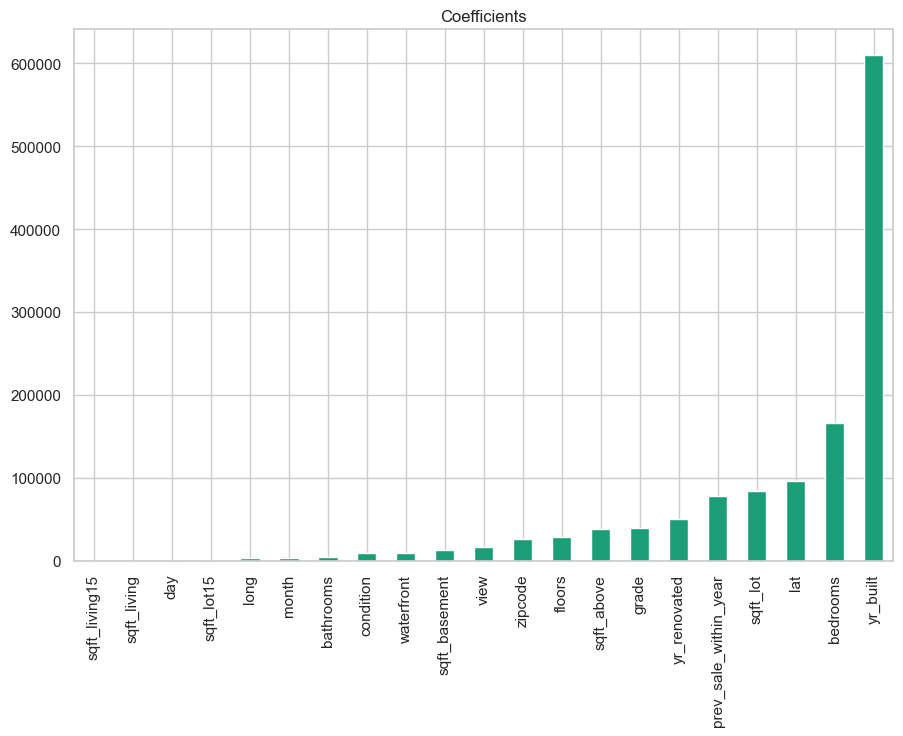

In [2897]:
for i in [0.3, 0.5, 0.7, 1]:       
       alpha = i
       lm_lasso = linear_model.Lasso(alpha=alpha).fit(X_train_scaled,y_train)

       res = {'type': 'lm-lasso',
              'scaled': True,
              'metaparams': f'alpha: {alpha}',
              'dropped': 'day,zipcode,yr_renovated,yr_built',
              'transformed': 'renovation_cat,built_cat,basement_cat'}
       res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm_lasso,X_train_scaled,X_test_scaled,y_train,y_test)
       coeff_plot(lm_lasso,X.columns)

       # append results to result_lst
       lm_result_lst.append(res)

Metrics for training set

r²-score 0.6831728089180806
r² adjusted: 0.6827875083034918
rMSE: 206793.7409113766
MAE: 124667.99014434448
ratio MAE/max(target): 0.0162

Metrics for test set

r²-score 0.6759923334205558
r² adjusted: 0.6744103383035671
rMSE: 208351.1271693648
MAE: 125383.68286831884
ratio MAE/max(target): 0.0163



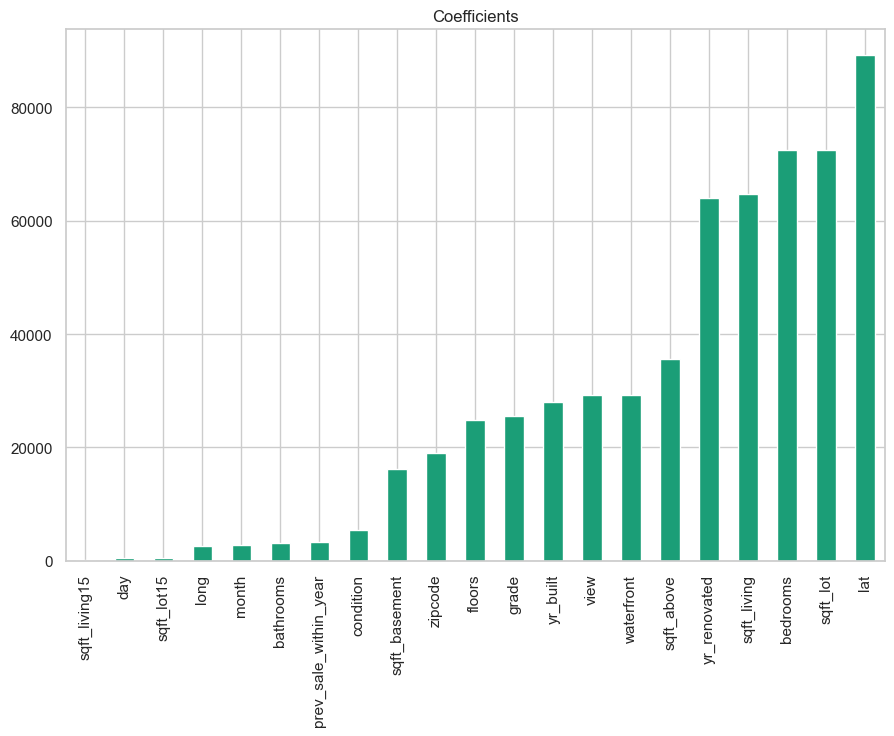

Metrics for training set

r²-score 0.6771572475258545
r² adjusted: 0.6767646312528665
rMSE: 208747.69412486086
MAE: 124117.5336993863
ratio MAE/max(target): 0.0161

Metrics for test set

r²-score 0.67090214380169
r² adjusted: 0.6692952953989547
rMSE: 209981.35684194037
MAE: 124737.29725424272
ratio MAE/max(target): 0.0162



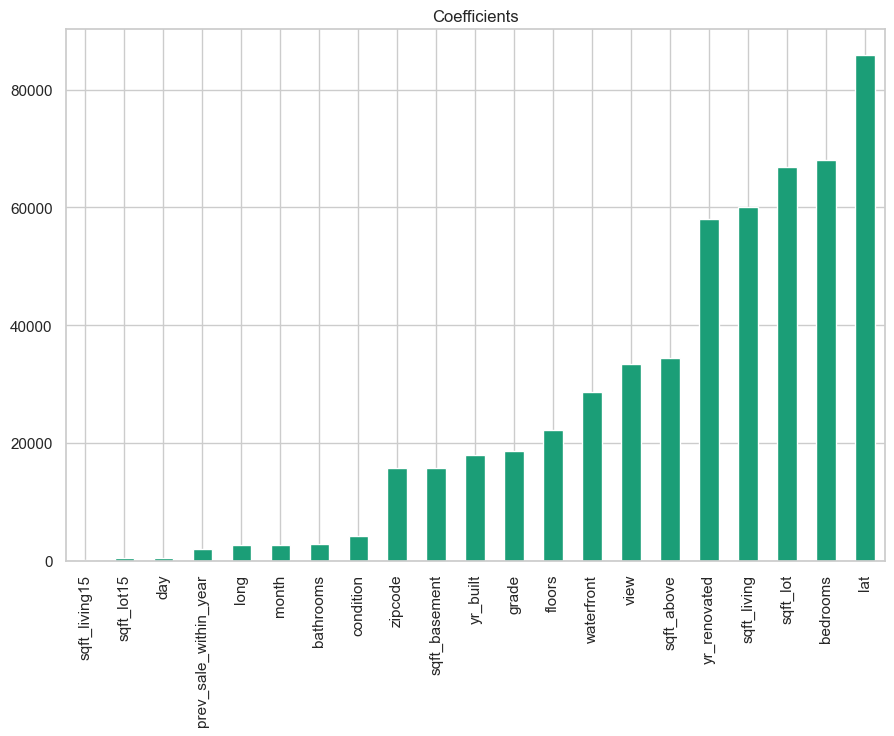

Metrics for training set

r²-score 0.6707845093320466
r² adjusted: 0.6703841430299834
rMSE: 210797.90832012886
MAE: 124022.32551068482
ratio MAE/max(target): 0.0161

Metrics for test set

r²-score 0.6651338175970036
r² adjusted: 0.6634988048486979
rMSE: 211813.60732124068
MAE: 124486.10592326816
ratio MAE/max(target): 0.0162



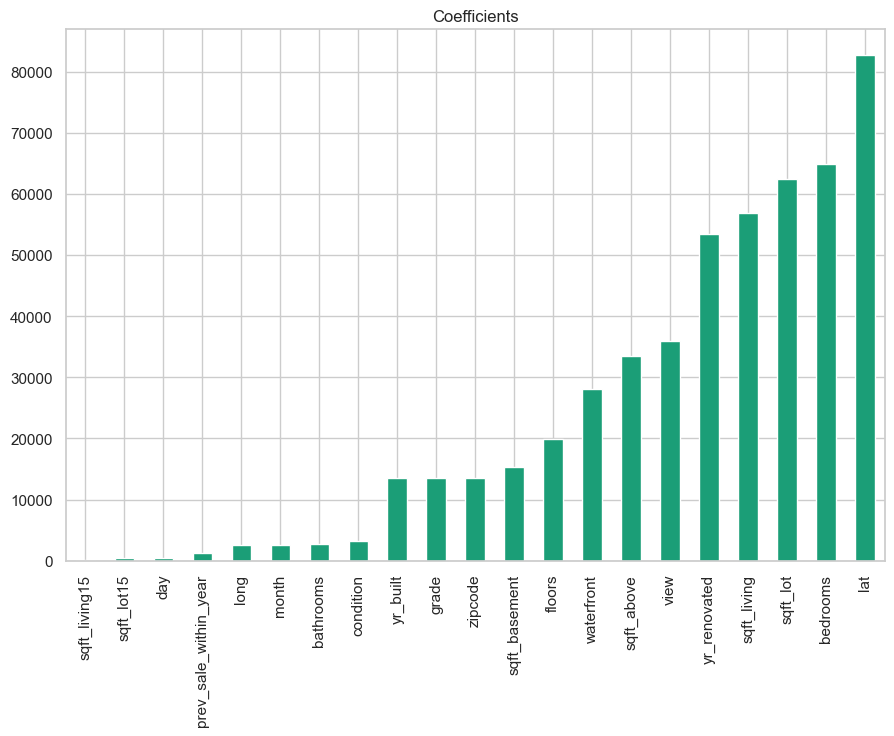

Metrics for training set

r²-score 0.6608327449644833
r² adjusted: 0.660420276099777
rMSE: 213960.2637013241
MAE: 124417.48581556017
ratio MAE/max(target): 0.0162

Metrics for test set

r²-score 0.655784161777522
r² adjusted: 0.6541034985357941
rMSE: 214750.22907986995
MAE: 124667.00557108919
ratio MAE/max(target): 0.0162



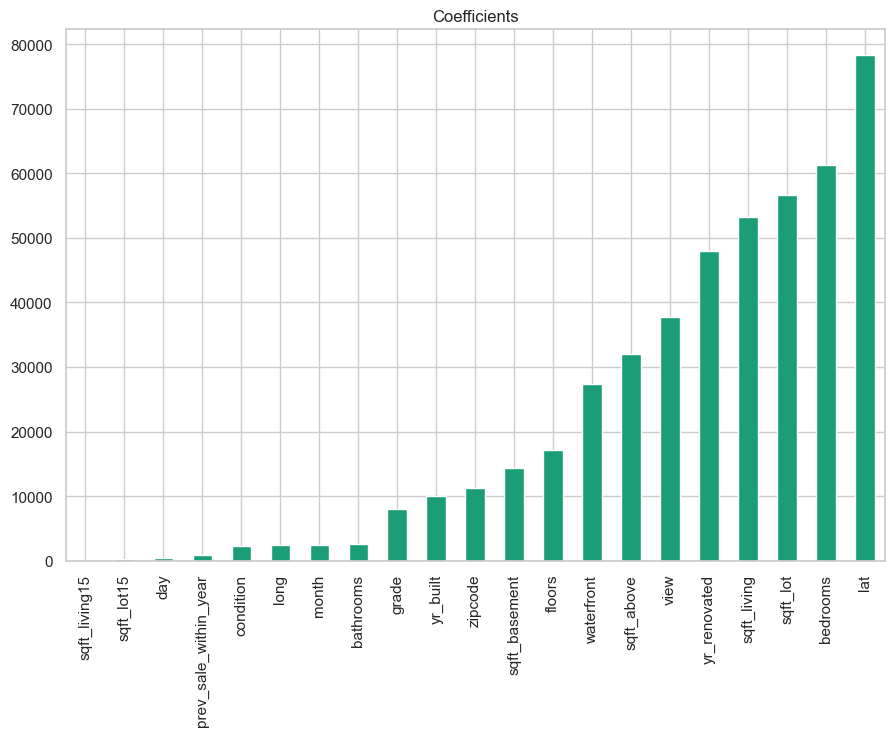

In [2898]:
for i in [0.3, 0.5, 0.7, 1]:       
       alpha = i
       lm_elnet = linear_model.ElasticNet(alpha=alpha).fit(X_train_scaled,y_train)

       res = {'type': 'lm-elnet',
              'scaled': True,
              'metaparams': f'alpha: {alpha}',
              'dropped': 'day,zipcode,yr_renovated,yr_built',
              'transformed': 'renovation_cat,built_cat,basement_cat'}
       res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(lm_elnet,X_train_scaled,X_test_scaled,y_train,y_test)
       coeff_plot(lm_elnet,X.columns)

       # append results to result_lst
       lm_result_lst.append(res)

In [2899]:
lm_results = pd.DataFrame(lm_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(lm_results)


,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
2,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,NaN
11,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,"renovation_cat,built_cat,basement_cat"
10,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684340,125477.226250,126751.891169,alpha: 0.7,NaN,"renovation_cat,built_cat,basement_cat"
9,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684340,125477.225957,126751.970618,alpha: 0.5,NaN,"renovation_cat,built_cat,basement_cat"
8,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684339,125477.225753,126752.050066,alpha: 0.3,NaN,"renovation_cat,built_cat,basement_cat"
1,lm,,True,0.703827,0.684338,125477.225447,126752.169239,NaN,NaN,NaN
0,lm,,False,0.703827,0.684338,125477.225447,126752.169239,NaN,NaN,NaN
6,lm,"day,zipcode,yr_renovated,yr_built",True,0.705510,0.681098,125160.959311,126144.838142,NaN,OHE,"renovation_cat,built_cat,basement_cat"
4,lm,"day,zipcode,yr_renovated,yr_built",False,0.705510,0.681098,125160.959311,126144.838142,NaN,OHE,"renovation_cat,built_cat,basement_cat"
12,lm-elnet,"day,zipcode,yr_renovated,yr_built",True,0.682788,0.674410,124667.990144,125383.682868,alpha: 0.3,NaN,"renovation_cat,built_cat,basement_cat"


ElasticNet yields better r² values with a lower alpha (better means moving towards the stronger results of the plain linear model), but at the price of higher error values.

The linear model with lasso regularisation with alpha set to 1 yields the strongest result by a small margin.



In [2900]:
overall_results = pd.concat([overall_results,lm_results.head(3)],ignore_index=True).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
overall_results
#display(overall_results)

,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
0,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,NaN
1,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,"renovation_cat,built_cat,basement_cat"
2,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684340,125477.226250,126751.891169,alpha: 0.7,NaN,"renovation_cat,built_cat,basement_cat"


# KNN

In [2901]:
from sklearn.neighbors import KNeighborsRegressor

for i in [4,5,6,7,8,9,10,15]:
       # define hyperparameters here
       k = i
       knn = KNeighborsRegressor(n_neighbors = k)
       knn.fit(X_OHE_train_scaled,y_train)

       res = {'type': 'knn',
              'scaled': True,
              'transform': 'OHE',
              'metaparams': f'k: {k}',
              'dropped': 'day,zipcode,yr_renovated,yr_built',
              'transformed': 'renovation_cat,built_cat,basement_cat'}
       res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(knn,X_OHE_train_scaled,X_OHE_test_scaled,y_train,y_test)
       #coeff_plot(knn,X.columns)

       # append results to result_lst
       knn_result_lst.append(res)

Metrics for training set

r²-score 0.8591148222861363
r² adjusted: 0.8588617546937658
rMSE: 137898.27015573674
MAE: 77609.16390977443
ratio MAE/max(target): 0.0101

Metrics for test set

r²-score 0.7698192644851728
r² adjusted: 0.7681563414367086
rMSE: 175611.39702023703
MAE: 100260.06072172102
ratio MAE/max(target): 0.013

Metrics for training set

r²-score 0.8471260522539582
r² adjusted: 0.8468514496128569
rMSE: 143645.79147008937
MAE: 80530.81622903411
ratio MAE/max(target): 0.0105

Metrics for test set

r²-score 0.7834894347722277
r² adjusted: 0.7819252708192888
rMSE: 170316.90557626166
MAE: 98278.29141799676
ratio MAE/max(target): 0.0128

Metrics for training set

r²-score 0.8381439786794679
r² adjusted: 0.8378532418234628
rMSE: 147805.50052610697
MAE: 82691.13830730673
ratio MAE/max(target): 0.0107

Metrics for test set

r²-score 0.7837192073145685
r² adjusted: 0.7821567033357177
rMSE: 170226.50690061192
MAE: 97932.76902613926
ratio MAE/max(target): 0.0127

Metrics for training s

In [2902]:
for i in [4, 5, 6, 7, 8,9,10, 15]:
    # define hyperparameters here
    k = i
    knn2 = KNeighborsRegressor(n_neighbors = k)
    knn2.fit(X_labels_train_scaled,y_train)

    res = {'type': 'knn',
        'scaled': True,
        'transform': 'labels',
        'metaparams': f'k: {k}',
        'dropped': 'day,zipcode,yr_renovated,yr_built',
        'transformed': 'renovation_cat,built_cat,basement_cat'}
    res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(knn2,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)
    #coeff_plot(knn,X.columns)

    # append results to result_lst
    knn_result_lst.append(res)

Metrics for training set

r²-score 0.8573349556590097
r² adjusted: 0.857177999327656
rMSE: 138766.60208674418
MAE: 76735.64650086756
ratio MAE/max(target): 0.01

Metrics for test set

r²-score 0.7699747717811452
r² adjusted: 0.7689590898531511
rMSE: 175552.0665394038
MAE: 99616.80048577377
ratio MAE/max(target): 0.0129

Metrics for training set

r²-score 0.8431030755846194
r² adjusted: 0.8429304617129406
rMSE: 145523.58375198327
MAE: 79585.35946790053
ratio MAE/max(target): 0.0103

Metrics for test set

r²-score 0.7763731748286662
r² adjusted: 0.7753857452032291
rMSE: 173093.26109324992
MAE: 97635.69461022437
ratio MAE/max(target): 0.0127

Metrics for training set

r²-score 0.8348673248599962
r² adjusted: 0.8346856502318746
rMSE: 149294.1101078144
MAE: 81517.44076537497
ratio MAE/max(target): 0.0106

Metrics for test set

r²-score 0.782664429010529
r² adjusted: 0.7817047785692555
rMSE: 170641.0902835765
MAE: 96247.15001156605
ratio MAE/max(target): 0.0125

Metrics for training set

r²-

In [2903]:

knn_results = pd.DataFrame(knn_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(knn_results)

overall_results = pd.concat([overall_results,knn_results.head(3)],ignore_index=True).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(overall_results)

,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test
5,knn,True,OHE,k: 9,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.817703,0.787200,86150.483677,95555.056365
3,knn,True,OHE,k: 7,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.829343,0.782849,84326.307990,97208.734245
2,knn,True,OHE,k: 6,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.837853,0.782157,82691.138307,97932.769026
1,knn,True,OHE,k: 5,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.846851,0.781925,80530.816229,98278.291418
4,knn,True,OHE,k: 8,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.822891,0.781837,85379.931745,96680.025619
6,knn,True,OHE,k: 10,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.813770,0.781755,86894.935963,95845.044969
10,knn,True,labels,k: 6,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.834686,0.781705,81517.440765,96247.150012
11,knn,True,labels,k: 7,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.828103,0.781483,82890.419326,95916.466409
12,knn,True,labels,k: 8,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.822625,0.777573,84039.063527,95569.717181
9,knn,True,labels,k: 5,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.842930,0.775386,79585.359468,97635.694610


,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
3,knn,"day,zipcode,yr_renovated,yr_built",True,0.817703,0.787200,86150.483677,95555.056365,k: 9,OHE,"renovation_cat,built_cat,basement_cat"
4,knn,"day,zipcode,yr_renovated,yr_built",True,0.829343,0.782849,84326.307990,97208.734245,k: 7,OHE,"renovation_cat,built_cat,basement_cat"
5,knn,"day,zipcode,yr_renovated,yr_built",True,0.837853,0.782157,82691.138307,97932.769026,k: 6,OHE,"renovation_cat,built_cat,basement_cat"
0,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,NaN
1,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,"renovation_cat,built_cat,basement_cat"
2,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684340,125477.226250,126751.891169,alpha: 0.7,NaN,"renovation_cat,built_cat,basement_cat"


KNN performs much better with smaller k on this dataset. The difference between OHE and labeled categorial variables is fairly small, with a small preference for labels over OHE. In order to balance a higher r²-score with lower MAE-scores, k=7 or k=8 seem to be promising choices. 

# GradientBoost

In [2904]:


lr =0.06
estim = 300
max_depth = 30
max_feat = 7
gradboost = ensemble.GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=lr,
                                n_estimators=estim,
                                max_depth =max_depth, 
                                random_state = 5,
                                max_features = max_feat)

gradboost.fit(X_OHE_train_scaled,y_train)


res = {'type': 'GradientBoost',
       'scaled': True,
       'transform': 'OHE',
       'metaparams': f'learning rate: {lr}, n_estim: {estim}, max_depth: {max_depth}, max_features: {max_feat}',
       'dropped': 'day,zipcode,yr_renovated,yr_built',
       'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(gradboost,X_OHE_train_scaled,X_OHE_test_scaled,y_train,y_test)
#coeff_plot(knn,X.columns)

# append results to result_lst
gradboost_result_lst.append(res)


Metrics for training set

r²-score 0.9998791588252843
r² adjusted: 0.9998789417621011
rMSE: 4038.6259866584237
MAE: 495.23065319225384
ratio MAE/max(target): 0.0001

Metrics for test set

r²-score 0.8982145878946306
r² adjusted: 0.8974792470008375
rMSE: 116777.98593935113
MAE: 68495.71244702511
ratio MAE/max(target): 0.0089



In [2905]:
lr =0.06
estim = 300
max_depth = 30
max_feat = 7
gradboost_lab = ensemble.GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=lr,
                                n_estimators=estim,
                                max_depth =max_depth, 
                                random_state = 5,
                                max_features = max_feat)

gradboost_lab.fit(X_labels_train_scaled,y_train)


res = {'type': 'GradientBoost',
       'scaled': True,
       'transform': 'labels',
       'metaparams': f'learning rate: {lr}, n_estim: {estim}, max_depth: {max_depth}, max_features: {max_feat}',
       'dropped': 'day,zipcode,yr_renovated,yr_built',
       'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(gradboost_lab,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)
#coeff_plot(knn,X.columns)

# append results to result_lst
gradboost_result_lst.append(res)

Metrics for training set

r²-score 0.9998197611697089
r² adjusted: 0.9998195628756861
rMSE: 4932.309792778406
MAE: 648.6198730227156
ratio MAE/max(target): 0.0001

Metrics for test set

r²-score 0.9024842839332032
r² adjusted: 0.9020537009433661
rMSE: 114302.44442962286
MAE: 65097.39507890789
ratio MAE/max(target): 0.0085



In [2906]:
gradboost_results = pd.DataFrame(gradboost_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(gradboost_results)

,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test
1,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.999820,0.902054,648.619873,65097.395079
0,GradientBoost,True,OHE,"learning rate: 0.06, n_estim: 300, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.999879,0.897479,495.230653,68495.712447


For GradientBoost, the dataset using labels also slightly outperforms the one using one-hot-encoding, so I'll be using labels below.

In [2907]:

gb_tests = [(0.06,150,30,7),
           (0.06,300,15,7),
           (0.06,300,15,12)]

for lr, estim, max_depth, max_feat in gb_tests:
       gradboost_lab = ensemble.GradientBoostingRegressor(loss='absolute_error',
                                   learning_rate=lr,
                                   n_estimators=estim,
                                   max_depth =max_depth, 
                                   random_state = 5,
                                   max_features = max_feat)

       gradboost_lab.fit(X_labels_train_scaled,y_train)


       res = {'type': 'GradientBoost',
              'scaled': True,
              'transform': 'labels',
              'metaparams': f'learning rate: {lr}, n_estim: {estim}, max_depth: {max_depth}, max_features: {max_feat}',
              'dropped': 'day,zipcode,yr_renovated,yr_built',
              'transformed': 'renovation_cat,built_cat,basement_cat'}
       res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(gradboost_lab,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)

       # append results to result_lst
       gradboost_result_lst.append(res)

Metrics for training set

r²-score 0.9985351595848565
r² adjusted: 0.99853354800594
rMSE: 14061.16560133453
MAE: 2377.034426696486
ratio MAE/max(target): 0.0003

Metrics for test set

r²-score 0.9011916904857773
r² adjusted: 0.9007554000184823
rMSE: 115057.50326048544
MAE: 65261.811429835514
ratio MAE/max(target): 0.0085

Metrics for training set

r²-score 0.991231461342045
r² adjusted: 0.9912218144263241
rMSE: 34402.482031951564
MAE: 11932.653798335426
ratio MAE/max(target): 0.0015

Metrics for test set

r²-score 0.900080334041341
r² adjusted: 0.8996391363529342
rMSE: 115702.75439843626
MAE: 64937.789416209846
ratio MAE/max(target): 0.0084

Metrics for training set

r²-score 0.9927497683190714
r² adjusted: 0.9927417918047727
rMSE: 31282.547200950088
MAE: 10322.905604146223
ratio MAE/max(target): 0.0013

Metrics for test set

r²-score 0.9058181137256819
r² adjusted: 0.905402251341482
rMSE: 112331.5892323271
MAE: 63306.01424394313
ratio MAE/max(target): 0.0082



In [2908]:
gradboost_results = pd.DataFrame(gradboost_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(gradboost_results)


,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test
4,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 12","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.992742,0.905402,10322.905604,63306.014244
1,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.999820,0.902054,648.619873,65097.395079
2,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 150, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.998534,0.900755,2377.034427,65261.811430
3,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.991222,0.899639,11932.653798,64937.789416
0,GradientBoost,True,OHE,"learning rate: 0.06, n_estim: 300, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.999879,0.897479,495.230653,68495.712447


In [2909]:
gb_tests = [(0.06,150,15,13),
           (0.06,150,20,13),
           (0.09,150,20,13),
           (0.05,100,20,11)]

for lr, estim, max_depth, max_feat in gb_tests:
       gradboost_lab = ensemble.GradientBoostingRegressor(loss='absolute_error',
                                   learning_rate=lr,
                                   n_estimators=estim,
                                   max_depth =max_depth, 
                                   random_state = 5,
                                   max_features = max_feat)

       gradboost_lab.fit(X_labels_train_scaled,y_train)


       res = {'type': 'GradientBoost',
              'scaled': True,
              'transform': 'labels',
              'metaparams': f'learning rate: {lr}, n_estim: {estim}, max_depth: {max_depth}, max_features: {max_feat}',
              'dropped': 'day,zipcode,yr_renovated,yr_built',
              'transformed': 'renovation_cat,built_cat,basement_cat'}
       res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(gradboost_lab,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)

       # append results to result_lst
       gradboost_result_lst.append(res)

Metrics for training set

r²-score 0.9867197442773372
r² adjusted: 0.9867051336891073
rMSE: 42337.90704924164
MAE: 15398.917993107116
ratio MAE/max(target): 0.002

Metrics for test set

r²-score 0.904357538233444
r² adjusted: 0.903935226643027
rMSE: 113199.25902467899
MAE: 64233.50469480215
ratio MAE/max(target): 0.0083

Metrics for training set

r²-score 0.9957835418301509
r² adjusted: 0.9957789029937163
rMSE: 23856.13393083049
MAE: 5168.706900319988
ratio MAE/max(target): 0.0007

Metrics for test set

r²-score 0.9066526293340234
r² adjusted: 0.9062404517735647
rMSE: 111832.81473937485
MAE: 64658.580789670246
ratio MAE/max(target): 0.0084

Metrics for training set

r²-score 0.9979540082575757
r² adjusted: 0.9979517573112465
rMSE: 16617.97512256537
MAE: 3511.191913883772
ratio MAE/max(target): 0.0005

Metrics for test set

r²-score 0.9086055383273276
r² adjusted: 0.9082019838835022
rMSE: 110656.81111062237
MAE: 64412.38595022194
ratio MAE/max(target): 0.0084

Metrics for training set



In [2910]:
gradboost_results = pd.DataFrame(gradboost_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(gradboost_results)

overall_results = pd.concat([overall_results,gradboost_results.head(3)],ignore_index=True).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(overall_results)

,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test
7,GradientBoost,True,labels,"learning rate: 0.09, n_estim: 150, max_depth: 20, max_features: 13","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.997952,0.908202,3511.191914,64412.385950
6,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 150, max_depth: 20, max_features: 13","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.995779,0.906240,5168.706900,64658.580790
4,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 12","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.992742,0.905402,10322.905604,63306.014244
5,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 150, max_depth: 15, max_features: 13","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.986705,0.903935,15398.917993,64233.504695
1,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.999820,0.902054,648.619873,65097.395079
2,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 150, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.998534,0.900755,2377.034427,65261.811430
3,GradientBoost,True,labels,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.991222,0.899639,11932.653798,64937.789416
0,GradientBoost,True,OHE,"learning rate: 0.06, n_estim: 300, max_depth: 30, max_features: 7","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.999879,0.897479,495.230653,68495.712447
8,GradientBoost,True,labels,"learning rate: 0.05, n_estim: 100, max_depth: 20, max_features: 11","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.971728,0.886562,14169.933862,65328.301141


,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
6,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.997952,0.908202,3511.191914,64412.385950,"learning rate: 0.09, n_estim: 150, max_depth: 20, max_features: 13",labels,"renovation_cat,built_cat,basement_cat"
7,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.995779,0.906240,5168.706900,64658.580790,"learning rate: 0.06, n_estim: 150, max_depth: 20, max_features: 13",labels,"renovation_cat,built_cat,basement_cat"
8,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.992742,0.905402,10322.905604,63306.014244,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 12",labels,"renovation_cat,built_cat,basement_cat"
0,knn,"day,zipcode,yr_renovated,yr_built",True,0.817703,0.787200,86150.483677,95555.056365,k: 9,OHE,"renovation_cat,built_cat,basement_cat"
1,knn,"day,zipcode,yr_renovated,yr_built",True,0.829343,0.782849,84326.307990,97208.734245,k: 7,OHE,"renovation_cat,built_cat,basement_cat"
2,knn,"day,zipcode,yr_renovated,yr_built",True,0.837853,0.782157,82691.138307,97932.769026,k: 6,OHE,"renovation_cat,built_cat,basement_cat"
3,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,NaN
4,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,"renovation_cat,built_cat,basement_cat"
5,lm-lasso,"day,zipcode,yr_renovated,yr_built",True,0.703827,0.684340,125477.226250,126751.891169,alpha: 0.7,NaN,"renovation_cat,built_cat,basement_cat"


# Random Forests

In [2911]:
estim_lst = [100,300]
max_depth_lst = [5, 30]
minsamp_split_lst = [2,5,10]
minsamp_leaf_lst = [1,3,5]


for est in estim_lst:
    for depth in max_depth_lst:
        for split in  minsamp_split_lst:
            for leaf in minsamp_leaf_lst:

                rf_regress = ensemble.RandomForestRegressor(n_estimators=est,
                                                            max_features='sqrt',
                                                            max_depth=max_depth,
                                                            min_samples_split=split,
                                                            min_samples_leaf=leaf,
                                                            random_state=5,
                                                            n_jobs=-1)

                rf_regress.fit(X_labels_train_scaled, y_train)


                res = {'type': 'RandomForests',
                            'scaled': True,
                            'transform': 'labels',
                            'metaparams': f'n_estim: {est}, max_depth: {depth}, minsamp_split: {split}, minsamp_leaf: {leaf}',
                            'dropped': 'day,zipcode,yr_renovated,yr_built',
                            'transformed': 'renovation_cat,built_cat,basement_cat'}
                res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(rf_regress,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)

                # append results to result_lst
                rf_result_lst.append(res)

Metrics for training set

r²-score 0.9800300654312332
r² adjusted: 0.9800080950341975
rMSE: 51917.58554360274
MAE: 30653.157663010035
ratio MAE/max(target): 0.004

Metrics for test set

r²-score 0.8773398409780798
r² adjusted: 0.8767982320955754
rMSE: 128194.67119199561
MAE: 72256.11058555207
ratio MAE/max(target): 0.0094

Metrics for training set

r²-score 0.9418812984625782
r² adjusted: 0.9418173577949921
rMSE: 88569.48464077615
MAE: 47726.20455242565
ratio MAE/max(target): 0.0062

Metrics for test set

r²-score 0.8738327132332289
r² adjusted: 0.8732756185438102
rMSE: 130014.44094771973
MAE: 73279.89224777507
ratio MAE/max(target): 0.0095

Metrics for training set

r²-score 0.9147236130402315
r² adjusted: 0.9146297942010748
rMSE: 107285.3845004506
MAE: 57052.32466397445
ratio MAE/max(target): 0.0074

Metrics for test set

r²-score 0.8669802157326176
r² adjusted: 0.8663928636756619
rMSE: 133498.48299751073
MAE: 74961.7093688138
ratio MAE/max(target): 0.0097

Metrics for training set



In [2912]:
rf_results = pd.DataFrame(rf_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display_scrollable_df(rf_results)

overall_results = pd.concat([overall_results,rf_results.head(3)],ignore_index=True).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display(overall_results)



,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test
18,RandomForests,True,labels,"n_estim: 300, max_depth: 5, minsamp_split: 2, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.980163,0.879147,30229.927748,71517.825482
27,RandomForests,True,labels,"n_estim: 300, max_depth: 30, minsamp_split: 2, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.980163,0.879147,30229.927748,71517.825482
0,RandomForests,True,labels,"n_estim: 100, max_depth: 5, minsamp_split: 2, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.980008,0.876798,30653.157663,72256.110586
9,RandomForests,True,labels,"n_estim: 100, max_depth: 30, minsamp_split: 2, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.980008,0.876798,30653.157663,72256.110586
21,RandomForests,True,labels,"n_estim: 300, max_depth: 5, minsamp_split: 5, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.966559,0.875691,37401.451678,71827.081145
30,RandomForests,True,labels,"n_estim: 300, max_depth: 30, minsamp_split: 5, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.966559,0.875691,37401.451678,71827.081145
24,RandomForests,True,labels,"n_estim: 300, max_depth: 5, minsamp_split: 10, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.945130,0.873882,47018.727493,72620.849486
33,RandomForests,True,labels,"n_estim: 300, max_depth: 30, minsamp_split: 10, minsamp_leaf: 1","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.945130,0.873882,47018.727493,72620.849486
1,RandomForests,True,labels,"n_estim: 100, max_depth: 5, minsamp_split: 2, minsamp_leaf: 3","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.941817,0.873276,47726.204552,73279.892248
4,RandomForests,True,labels,"n_estim: 100, max_depth: 5, minsamp_split: 5, minsamp_leaf: 3","day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.941817,0.873276,47726.204552,73279.892248


,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
0,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.997952,0.908202,3511.191914,64412.385950,"learning rate: 0.09, n_estim: 150, max_depth: 20, max_features: 13",labels,"renovation_cat,built_cat,basement_cat"
1,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.995779,0.906240,5168.706900,64658.580790,"learning rate: 0.06, n_estim: 150, max_depth: 20, max_features: 13",labels,"renovation_cat,built_cat,basement_cat"
2,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.992742,0.905402,10322.905604,63306.014244,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 12",labels,"renovation_cat,built_cat,basement_cat"
9,RandomForests,"day,zipcode,yr_renovated,yr_built",True,0.980163,0.879147,30229.927748,71517.825482,"n_estim: 300, max_depth: 5, minsamp_split: 2, minsamp_leaf: 1",labels,"renovation_cat,built_cat,basement_cat"
10,RandomForests,"day,zipcode,yr_renovated,yr_built",True,0.980163,0.879147,30229.927748,71517.825482,"n_estim: 300, max_depth: 30, minsamp_split: 2, minsamp_leaf: 1",labels,"renovation_cat,built_cat,basement_cat"
11,RandomForests,"day,zipcode,yr_renovated,yr_built",True,0.980008,0.876798,30653.157663,72256.110586,"n_estim: 100, max_depth: 5, minsamp_split: 2, minsamp_leaf: 1",labels,"renovation_cat,built_cat,basement_cat"
3,knn,"day,zipcode,yr_renovated,yr_built",True,0.817703,0.787200,86150.483677,95555.056365,k: 9,OHE,"renovation_cat,built_cat,basement_cat"
4,knn,"day,zipcode,yr_renovated,yr_built",True,0.829343,0.782849,84326.307990,97208.734245,k: 7,OHE,"renovation_cat,built_cat,basement_cat"
5,knn,"day,zipcode,yr_renovated,yr_built",True,0.837853,0.782157,82691.138307,97932.769026,k: 6,OHE,"renovation_cat,built_cat,basement_cat"
6,lm-lasso,,True,0.703827,0.684341,125477.226877,126751.771997,alpha: 1,NaN,NaN


RandomForestRegressor reaches up to about 0.87, so not quite reaching as high as GradientBoost

# XGBoost

In [2913]:
import xgboost as xgb

In [2914]:
# check with OHE

xgb_model = xgb.XGBRegressor(random_state=1)
xgb_model.fit(X_OHE_train_scaled, y_train)


res = {'type': 'XGBoost',
            'scaled': True,
            'transform': 'OHE',
            'metaparams': '',
            'dropped': 'day,zipcode,yr_renovated,yr_built',
            'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_OHE_train_scaled,X_OHE_test_scaled,y_train,y_test)

# append results to result_lst
xgb_result_lst.append(res)

Metrics for training set

r²-score 0.9751035345123971
r² adjusted: 0.9750588137782381
rMSE: 57968.89392239654
MAE: 41101.99830375217
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9042599606742587
r² adjusted: 0.9035682941118961
rMSE: 113256.98909211834
MAE: 65598.39261833507
ratio MAE/max(target): 0.0085



In [2915]:
# check with labels

xgb_model = xgb.XGBRegressor(random_state=1)
xgb_model.fit(X_labels_train_scaled, y_train)


res = {'type': 'XGBoost',
            'scaled': True,
            'transform': 'labels',
            'metaparams': '',
            'dropped': 'day,zipcode,yr_renovated,yr_built',
            'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train_scaled,X_labels_test_scaled,y_train,y_test)

# append results to result_lst
xgb_result_lst.append(res)

Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9108068111409676
r² adjusted: 0.910412976470198
rMSE: 109316.08173213048
MAE: 65647.11460863404
ratio MAE/max(target): 0.0085



Labels yield slightly better result. Test unscaled data as well.

In [2916]:
# UNSCALED
# OHE
xgb_model = xgb.XGBRegressor(random_state=1)
xgb_model.fit(X_OHE_train, y_train)


res = {'type': 'XGBoost',
            'scaled': False,
            'transform': 'OHE',
            'metaparams': '',
            'dropped': 'day,zipcode,yr_renovated,yr_built',
            'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_OHE_train,X_OHE_test,y_train,y_test)

# append results to result_lst
xgb_result_lst.append(res)

Metrics for training set

r²-score 0.9751035345123971
r² adjusted: 0.9750588137782381
rMSE: 57968.89392239654
MAE: 41101.99830375217
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.908774707880515
r² adjusted: 0.9081156577626627
rMSE: 110554.35176316806
MAE: 65371.535990270066
ratio MAE/max(target): 0.0085



In [2917]:
# UNSCALED
# labels
xgb_model = xgb.XGBRegressor(random_state=1)
xgb_model.fit(X_labels_train, y_train)


res = {'type': 'XGBoost',
            'scaled': False,
            'transform': 'labels',
            'metaparams': '',
            'dropped': 'day,zipcode,yr_renovated,yr_built',
            'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train,X_labels_test,y_train,y_test)

# append results to result_lst
xgb_result_lst.append(res)

Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



XGBoost yields a better result with unscaled data! Indeed, it appears to offer the best result of all models tested so far, using unscaled data and labels-encoding.

## XGBoost tuning

In [2918]:
# try increasing estimators to see effect before iterative testing


estim = 10
lr = 0.3
booster = 'dart'    # 'gbtree' (default), 'dart'
dart_nominalized_type = 'TREE'  # for dart booster: 'TREE' (default), 'FOREST'
min_child_weight = 1
max_depth = 6   # default 6
subsample = 1   # subsample ratio of the training instance, def 1.0
reg_alpha = 0   # def 0, L1 regularisation ()
reg_lambda = 1  # default 1, L2 regularisation (Lasso)
max_iterations = 20

# UNSCALED
# labels
xgb_model = xgb.XGBRegressor(random_state=1,
                            n_estimator = estim,
                            lr = lr,
                            booster = booster,    # 'gbtree' (default), 'dart'
                            dart_nominalized_type = dart_nominalized_type,  # for dart booster: 'TREE' (default), 'FOREST'
                            min_child_weight = min_child_weight,
                            max_depth = max_depth,   # default 6
                            subsample = subsample,   # subsample ratio of the training instance, def 1.0
                            reg_alpha = reg_alpha,   # def 0, L1 regularisation ()
                            reg_lambda = reg_lambda,  # default 1, L2 regularisation (Lasso)
                            max_iterations = max_iterations)
xgb_model.fit(X_labels_train, y_train)


res = {'type': 'XGBoost',
            'scaled': False,
            'transform': 'labels',
            'estimators': estim,
            'booster': booster,
            'dart_nominalized_type': dart_nominalized_type,
            'min_child_weight': min_child_weight,
            'max_depth': max_depth,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'learning rate': lr,
            'max_iterations': max_iterations,
            'dropped': 'day,zipcode,yr_renovated,yr_built',
            'transformed': 'renovation_cat,built_cat,basement_cat'}
res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train,X_labels_test,y_train,y_test)

# append results to result_lst
xgb_result_lst.append(res)

/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



In [2919]:
boostlst = ['gbtree','dart']
estim_lst = [2,5]
lr_lst = [0.4, 0.1, 0.05]

for booster in boostlst:
    for estim in estim_lst:
        for lr in lr_lst:
        
                # UNSCALED
                # labels
                xgb_model = xgb.XGBRegressor(random_state=1,
                                            n_estimator = estim,
                                            lr = lr,
                                            booster = booster,    # 'gbtree' (default), 'dart'
                                            dart_nominalized_type = dart_nominalized_type,  # for dart booster: 'TREE' (default), 'FOREST'
                                            min_child_weight = min_child_weight,
                                            max_depth = max_depth,   # default 6
                                            subsample = subsample,   # subsample ratio of the training instance, def 1.0
                                            reg_alpha = reg_alpha,   # def 0, L1 regularisation ()
                                            reg_lambda = reg_lambda,  # default 1, L2 regularisation (Lasso)
                                            max_iterations = max_iterations)
                xgb_model.fit(X_labels_train, y_train)


                res = {'type': 'XGBoost',
                            'scaled': False,
                            'transform': 'labels',
                            'estimators': estim,
                            'booster': booster,
                            'dart_nominalized_type': dart_nominalized_type,
                            'min_child_weight': min_child_weight,
                            'max_depth': max_depth,
                            'reg_alpha': reg_alpha,
                            'reg_lambda': reg_lambda,
                            'learning rate': lr,
                            'max_iterations': max_iterations,
                            'dropped': 'day,zipcode,yr_renovated,yr_built',
                            'transformed': 'renovation_cat,built_cat,basement_cat'}
                res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train,X_labels_test,y_train,y_test)

                # append results to result_lst
                xgb_result_lst.append(res)

/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:38:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:38:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:38:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



In [2920]:
xgb_results = pd.DataFrame(xgb_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display_scrollable_df(xgb_results)


,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test,estimators,booster,dart_nominalized_type,min_child_weight,max_depth,reg_alpha,reg_lambda,learning rate,max_iterations
3,XGBoost,False,labels,,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000
6,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000
7,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.050000,20.000000
8,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000
9,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000
10,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.050000,20.000000
4,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,10.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.300000,20.000000
11,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,2.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000
12,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,2.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000


No differences in results at all. Obviously, no impact of these three parameters here (at least not in this combination?).

In [2921]:
estim = 1
lr = 0.3
booster = 'dart'    # 'gbtree' (default), 'dart'
dart_nominalized_type = 'TREE'  # for dart booster: 'TREE' (default), 'FOREST'
min_child_weight = 1
max_depth = 6   # default 6
subsample = 1   # subsample ratio of the training instance, def 1.0
reg_alpha = 0   # def 0, L1 regularisation ()
reg_lambda = 1  # default 1, L2 regularisation (Lasso)
max_iterations = 20

dartnom_lst = ['TREE', 'FOREST']
lr_lst = [0.5,0.3,0.1]
subsamp_lst = [1, 0.8, 0.5]

for dart_nominalized_type in dartnom_lst:
    for subsample in subsamp_lst:
        for lr in lr_lst:
        
                # UNSCALED
                # labels
                xgb_model = xgb.XGBRegressor(random_state=1,
                                            n_estimator = estim,
                                            lr = lr,
                                            booster = booster,    # 'gbtree' (default), 'dart'
                                            dart_nominalized_type = dart_nominalized_type,  # for dart booster: 'TREE' (default), 'FOREST'
                                            min_child_weight = min_child_weight,
                                            max_depth = max_depth,   # default 6
                                            subsample = subsample,   # subsample ratio of the training instance, def 1.0
                                            reg_alpha = reg_alpha,   # def 0, L1 regularisation ()
                                            reg_lambda = reg_lambda,  # default 1, L2 regularisation (Lasso)
                                            max_iterations = max_iterations)
                xgb_model.fit(X_labels_train, y_train)


                res = {'type': 'XGBoost',
                            'scaled': False,
                            'transform': 'labels',
                            'estimators': estim,
                            'booster': booster,
                            'dart_nominalized_type': dart_nominalized_type,
                            'min_child_weight': min_child_weight,
                            'max_depth': max_depth,
                            'reg_alpha': reg_alpha,
                            'reg_lambda': reg_lambda,
                            'learning rate': lr,
                            'subsample': subsample,
                            'max_iterations': max_iterations,
                            'dropped': 'day,zipcode,yr_renovated,yr_built',
                            'transformed': 'renovation_cat,built_cat,basement_cat'}
                res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train,X_labels_test,y_train,y_test)

                # append results to result_lst
                xgb_result_lst.append(res)

/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9747149916790749
r² adjusted: 0.9746871737776217
rMSE: 58419.483995542345
MAE: 41648.52605371602
ratio MAE/max(target): 0.0054

Metrics for test set

r²-score 0.9023572463671031
r² adjusted: 0.9019261024398373
rMSE: 114376.87334646632
MAE: 66689.0439437312
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9747149916790749
r² adjusted: 0.9746871737776217
rMSE: 58419.483995542345
MAE: 41648.52605371602
ratio MAE/max(target): 0.0054

Metrics for test set

r²-score 0.9023572463671031
r² adjusted: 0.9019261024398373
rMSE: 114376.87334646632
MAE: 66689.0439437312
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9747149916790749
r² adjusted: 0.9746871737776217
rMSE: 58419.483995542345
MAE: 41648.52605371602
ratio MAE/max(target): 0.0054

Metrics for test set

r²-score 0.9023572463671031
r² adjusted: 0.9019261024398373
rMSE: 114376.87334646632
MAE: 66689.0439437312
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9679252432696436
r² adjusted: 0.9678899554654816
rMSE: 65797.26653718443
MAE: 47266.36814090515
ratio MAE/max(target): 0.0061

Metrics for test set

r²-score 0.8912631986600474
r² adjusted: 0.890783068698286
rMSE: 120699.78257608344
MAE: 68742.31427827898
ratio MAE/max(target): 0.0089



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9679252432696436
r² adjusted: 0.9678899554654816
rMSE: 65797.26653718443
MAE: 47266.36814090515
ratio MAE/max(target): 0.0061

Metrics for test set

r²-score 0.8912631986600474
r² adjusted: 0.890783068698286
rMSE: 120699.78257608344
MAE: 68742.31427827898
ratio MAE/max(target): 0.0089



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9679252432696436
r² adjusted: 0.9678899554654816
rMSE: 65797.26653718443
MAE: 47266.36814090515
ratio MAE/max(target): 0.0061

Metrics for test set

r²-score 0.8912631986600474
r² adjusted: 0.890783068698286
rMSE: 120699.78257608344
MAE: 68742.31427827898
ratio MAE/max(target): 0.0089



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754050075614712
r² adjusted: 0.9753779487973524
rMSE: 57616.85024221321
MAE: 40600.86394050029
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932150722133
r² adjusted: 0.9126090345205916
rMSE: 107967.92913607677
MAE: 65516.94147582697
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9747149916790749
r² adjusted: 0.9746871737776217
rMSE: 58419.483995542345
MAE: 41648.52605371602
ratio MAE/max(target): 0.0054

Metrics for test set

r²-score 0.9023572463671031
r² adjusted: 0.9019261024398373
rMSE: 114376.87334646632
MAE: 66689.0439437312
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9747149916790749
r² adjusted: 0.9746871737776217
rMSE: 58419.483995542345
MAE: 41648.52605371602
ratio MAE/max(target): 0.0054

Metrics for test set

r²-score 0.9023572463671031
r² adjusted: 0.9019261024398373
rMSE: 114376.87334646632
MAE: 66689.0439437312
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9747149916790749
r² adjusted: 0.9746871737776217
rMSE: 58419.483995542345
MAE: 41648.52605371602
ratio MAE/max(target): 0.0054

Metrics for test set

r²-score 0.9023572463671031
r² adjusted: 0.9019261024398373
rMSE: 114376.87334646632
MAE: 66689.0439437312
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9679252432696436
r² adjusted: 0.9678899554654816
rMSE: 65797.26653718443
MAE: 47266.36814090515
ratio MAE/max(target): 0.0061

Metrics for test set

r²-score 0.8912631986600474
r² adjusted: 0.890783068698286
rMSE: 120699.78257608344
MAE: 68742.31427827898
ratio MAE/max(target): 0.0089



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9679252432696436
r² adjusted: 0.9678899554654816
rMSE: 65797.26653718443
MAE: 47266.36814090515
ratio MAE/max(target): 0.0061

Metrics for test set

r²-score 0.8912631986600474
r² adjusted: 0.890783068698286
rMSE: 120699.78257608344
MAE: 68742.31427827898
ratio MAE/max(target): 0.0089



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9679252432696436
r² adjusted: 0.9678899554654816
rMSE: 65797.26653718443
MAE: 47266.36814090515
ratio MAE/max(target): 0.0061

Metrics for test set

r²-score 0.8912631986600474
r² adjusted: 0.890783068698286
rMSE: 120699.78257608344
MAE: 68742.31427827898
ratio MAE/max(target): 0.0089



In [2922]:
xgb_results = pd.DataFrame(xgb_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display_scrollable_df(xgb_results)


,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test,estimators,booster,dart_nominalized_type,min_child_weight,max_depth,reg_alpha,reg_lambda,learning rate,max_iterations,subsample
3,XGBoost,False,labels,,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000,NaN
6,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000,NaN
7,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.050000,20.000000,NaN
8,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000,NaN
9,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000,NaN
10,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.050000,20.000000,NaN
4,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,10.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.300000,20.000000,NaN
11,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,2.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000,NaN
12,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,2.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000,NaN


Dropping subsample value leads to worse results. TREE or FOREST version of dart booster does not seem to have an impact here.

In [2923]:
estim = 1
lr = 0.3
booster = 'gbtree'    # 'gbtree' (default), 'dart'
dart_nominalized_type = 'TREE'  # for dart booster: 'TREE' (default), 'FOREST'
min_child_weight = 1
max_depth = 6   # default 6
subsample = 1   # subsample ratio of the training instance, def 1.0
reg_alpha = 0   # def 0, L1 regularisation ()
reg_lambda = 1  # default 1, L2 regularisation (Lasso)
max_iterations = 20

childweight_lst = [1,3]
depth_lst = [3,6,12]

for min_child_weight in childweight_lst:
    for max_depth in depth_lst:
    
            # UNSCALED
            # labels
            xgb_model = xgb.XGBRegressor(random_state=1,
                                        n_estimator = estim,
                                        lr = lr,
                                        booster = booster,    # 'gbtree' (default), 'dart'
                                        dart_nominalized_type = dart_nominalized_type,  # for dart booster: 'TREE' (default), 'FOREST'
                                        min_child_weight = min_child_weight,
                                        max_depth = max_depth,   # default 6
                                        subsample = subsample,   # subsample ratio of the training instance, def 1.0
                                        reg_alpha = reg_alpha,   # def 0, L1 regularisation ()
                                        reg_lambda = reg_lambda,  # default 1, L2 regularisation (Lasso)
                                        max_iterations = max_iterations)
            xgb_model.fit(X_labels_train, y_train)


            res = {'type': 'XGBoost',
                        'scaled': False,
                        'transform': 'labels',
                        'estimators': estim,
                        'booster': booster,
                        'dart_nominalized_type': dart_nominalized_type,
                        'min_child_weight': min_child_weight,
                        'max_depth': max_depth,
                        'reg_alpha': reg_alpha,
                        'reg_lambda': reg_lambda,
                        'learning rate': lr,
                        'subsample': subsample,
                        'max_iterations': max_iterations,
                        'dropped': 'day,zipcode,yr_renovated,yr_built',
                        'transformed': 'renovation_cat,built_cat,basement_cat'}
            res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train,X_labels_test,y_train,y_test)

            # append results to result_lst
            xgb_result_lst.append(res)

Metrics for training set

r²-score 0.9198889028943851
r² adjusted: 0.9198007667713389
rMSE: 103985.4333100968
MAE: 67177.23265254483
ratio MAE/max(target): 0.0087

Metrics for test set

r²-score 0.8867284048741808
r² adjusted: 0.8862282514213826
rMSE: 123190.92587169456
MAE: 72713.28400416377
ratio MAE/max(target): 0.0094



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9998252026485733
r² adjusted: 0.9998250103411225
rMSE: 4857.285042050312
MAE: 3130.538365746096
ratio MAE/max(target): 0.0004

Metrics for test set

r²-score 0.8877634186514164
r² adjusted: 0.8872678353268467
rMSE: 122626.80867244863
MAE: 68300.43142059912
ratio MAE/max(target): 0.0089

Metrics for training set

r²-score 0.921400328683079
r² adjusted: 0.9213138553909527
rMSE: 102999.83551616991
MAE: 66296.66171558705
ratio MAE/max(target): 0.0086

Metrics for test set

r²-score 0.8973134587513591
r² adjusted: 0.8968600438585578
rMSE: 117293.77773526529
MAE: 71960.95567314365
ratio MAE/max(target): 0.0093



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9752451853348215
r² adjusted: 0.9752179507384904
rMSE: 57803.748901071696
MAE: 40881.85773026316
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9075815607736325
r² adjusted: 0.907173484932289
rMSE: 111274.98027844836
MAE: 66163.96995901284
ratio MAE/max(target): 0.0086



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9995874613833265
r² adjusted: 0.9995870075191855
rMSE: 7462.0554200282895
MAE: 4893.563648152834
ratio MAE/max(target): 0.0006

Metrics for test set

r²-score 0.906847095327274
r² adjusted: 0.9064357764360861
rMSE: 111716.26610215817
MAE: 65953.57234378615
ratio MAE/max(target): 0.0086



In [2924]:
xgb_results = pd.DataFrame(xgb_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
display_scrollable_df(xgb_results)



,type,scaled,transform,metaparams,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test,estimators,booster,dart_nominalized_type,min_child_weight,max_depth,reg_alpha,reg_lambda,learning rate,max_iterations,subsample
3,XGBoost,False,labels,,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000,NaN
6,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000,NaN
7,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,2.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.050000,20.000000,NaN
8,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000,NaN
9,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.100000,20.000000,NaN
10,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,5.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.050000,20.000000,NaN
36,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863523,65516.941429,1.000000,gbtree,TREE,1.000000,6.000000,0.000000,1.000000,0.300000,20.000000,1.000000
4,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,10.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.300000,20.000000,NaN
11,XGBoost,False,labels,NaN,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.975378,0.912609,40600.863941,65516.941476,2.000000,dart,TREE,1.000000,6.000000,0.000000,1.000000,0.400000,20.000000,NaN


deviations from standard for min_child_weight or max_depth do not lead to improvements.

In [2925]:
estim = 1
lr = 0.3
booster = 'gbtree'    # 'gbtree' (default), 'dart'
dart_nominalized_type = 'TREE'  # for dart booster: 'TREE' (default), 'FOREST'
min_child_weight = 1
max_depth = 6   # default 6
subsample = 1   # subsample ratio of the training instance, def 1.0
reg_alpha = 0   # def 0, L1 regularisation ()
reg_lambda = 1  # default 1, L2 regularisation (Lasso)
max_iterations = 20

alpha_lst = [0, 0.3, 0.5]
lambda_lst = [1, 0.75, 0.5]

for reg_alpha in alpha_lst:
    for reg_lambda in lambda_lst:
    
            # UNSCALED
            # labels
            xgb_model = xgb.XGBRegressor(random_state=1,
                                        n_estimator = estim,
                                        lr = lr,
                                        booster = booster,    # 'gbtree' (default), 'dart'
                                        dart_nominalized_type = dart_nominalized_type,  # for dart booster: 'TREE' (default), 'FOREST'
                                        min_child_weight = min_child_weight,
                                        max_depth = max_depth,   # default 6
                                        subsample = subsample,   # subsample ratio of the training instance, def 1.0
                                        reg_alpha = reg_alpha,   # def 0, L1 regularisation ()
                                        reg_lambda = reg_lambda,  # default 1, L2 regularisation (Lasso)
                                        max_iterations = max_iterations)
            xgb_model.fit(X_labels_train, y_train)


            res = {'type': 'XGBoost',
                        'scaled': False,
                        'transform': 'labels',
                        'estimators': estim,
                        'booster': booster,
                        'dart_nominalized_type': dart_nominalized_type,
                        'min_child_weight': min_child_weight,
                        'max_depth': max_depth,
                        'reg_alpha': reg_alpha,
                        'reg_lambda': reg_lambda,
                        'learning rate': lr,
                        'subsample': subsample,
                        'max_iterations': max_iterations,
                        'dropped': 'day,zipcode,yr_renovated,yr_built',
                        'transformed': 'renovation_cat,built_cat,basement_cat'}
            res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_labels_train,X_labels_test,y_train,y_test)

            # append results to result_lst
            xgb_result_lst.append(res)

/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.975405007182245
r² adjusted: 0.975377948417709
rMSE: 57616.85068640563
MAE: 40600.86352299017
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932234547278
r² adjusted: 0.9126090429401194
rMSE: 107967.92393508731
MAE: 65516.94142883993
ratio MAE/max(target): 0.0085

Metrics for training set

r²-score 0.9764510181842161
r² adjusted: 0.9764251102134865
rMSE: 56378.3333767324
MAE: 40135.41343894592
ratio MAE/max(target): 0.0052

Metrics for test set

r²-score 0.9089739842836648
r² adjusted: 0.9085720567218218
rMSE: 110433.53593724628
MAE: 65875.28736554476
ratio MAE/max(target): 0.0086



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9773066244124405
r² adjusted: 0.9772816577571908
rMSE: 55344.659097287135
MAE: 39684.2427667727
ratio MAE/max(target): 0.0052

Metrics for test set

r²-score 0.8999736259312632
r² adjusted: 0.8995319570706296
rMSE: 115764.5196554889
MAE: 66797.87258016712
ratio MAE/max(target): 0.0087

Metrics for training set

r²-score 0.9754050025254
r² adjusted: 0.9753779437557406
rMSE: 57616.85614102665
MAE: 40600.868277815935
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932281038806
r² adjusted: 0.9126090476098005
rMSE: 107967.92105048789
MAE: 65516.93947887752
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.976451012086901
r² adjusted: 0.9764251041094633
rMSE: 56378.34067548618
MAE: 40135.42031385555
ratio MAE/max(target): 0.0052

Metrics for test set

r²-score 0.9089739799059946
r² adjusted: 0.9085720523248219
rMSE: 110433.53859275956
MAE: 65875.28761132316
ratio MAE/max(target): 0.0086



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9773066191520997
r² adjusted: 0.9772816524910627
rMSE: 55344.66551175266
MAE: 39684.24838734456
ratio MAE/max(target): 0.0052

Metrics for test set

r²-score 0.8999736263366249
r² adjusted: 0.8995319574777813
rMSE: 115764.51942091824
MAE: 66797.87145247802
ratio MAE/max(target): 0.0087



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9754049992870343
r² adjusted: 0.9753779405138121
rMSE: 57616.85993416477
MAE: 40600.87089222455
ratio MAE/max(target): 0.0053

Metrics for test set

r²-score 0.9129932262854192
r² adjusted: 0.9126090457833098
rMSE: 107967.922178765
MAE: 65516.93834938122
ratio MAE/max(target): 0.0085



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9764510095618608
r² adjusted: 0.9764251015816452
rMSE: 56378.343698069824
MAE: 40135.42219219925
ratio MAE/max(target): 0.0052

Metrics for test set

r²-score 0.9089739925629114
r² adjusted: 0.9085720650376257
rMSE: 110433.53091501998
MAE: 65875.28267949051
ratio MAE/max(target): 0.0086



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9773066149055881
r² adjusted: 0.9772816482398792
rMSE: 55344.6706899532
MAE: 39684.252596786435
ratio MAE/max(target): 0.0052

Metrics for test set

r²-score 0.8999736308048117
r² adjusted: 0.8995319619656975
rMSE: 115764.51683531262
MAE: 66797.8707874306
ratio MAE/max(target): 0.0087



In [ ]:
xgb_results = pd.DataFrame(xgb_result_lst)
xgb_results = xgb_results.sort_values(by=['r2-adj-test','mae-test','estimators','booster'],ascending=[False,False,True,False])

cols_to_collapse = ['estimators', 'booster', 'subsample', 
                    'dart_nominalized_type',
                        'min_child_weight',
                        'max_depth',
                        'reg_alpha',
                        'reg_lambda',
                        'learning rate',
                        'max_iterations']  # list of columns to collapse
xgb_results['metaparams'] = xgb_results[cols_to_collapse].apply(
    lambda row: ','.join(f'{col}: {row[col]}' for col in cols_to_collapse), axis=1
)

xgb_results.head()

overall_results = pd.concat([overall_results,xgb_results.drop(columns=cols_to_collapse).head(3)],ignore_index=True).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])

# Summing up results

In [2927]:
display(overall_results)

,type,dropped,scaled,r2-adj-train,r2-adj-test,mae-train,mae-test,metaparams,transform,transformed
12,XGBoost,"day,zipcode,yr_renovated,yr_built",False,0.975378,0.912609,40600.868278,65516.939479,"estimators: 1.0,booster: gbtree,subsample: subsample 1.000000\nsubsample 1.000000\nName: 44, dtype: object,dart_nominalized_type: TREE,min_child_weight: 1.0,max_depth: 6.0,reg_alpha: 0.3,reg_lambda: 1.0,learning rate: 0.3,subsample: subsample 1.000000\nsubsample 1.000000\nName: 44, dtype: object,max_iterations: 20.0",labels,"renovation_cat,built_cat,basement_cat"
13,XGBoost,"day,zipcode,yr_renovated,yr_built",False,0.975378,0.912609,40600.870892,65516.938349,"estimators: 1.0,booster: gbtree,subsample: subsample 1.000000\nsubsample 1.000000\nName: 47, dtype: object,dart_nominalized_type: TREE,min_child_weight: 1.0,max_depth: 6.0,reg_alpha: 0.5,reg_lambda: 1.0,learning rate: 0.3,subsample: subsample 1.000000\nsubsample 1.000000\nName: 47, dtype: object,max_iterations: 20.0",labels,"renovation_cat,built_cat,basement_cat"
14,XGBoost,"day,zipcode,yr_renovated,yr_built",False,0.975378,0.912609,40600.863523,65516.941429,"estimators: 1.0,booster: gbtree,subsample: subsample 1.000000\nsubsample 1.000000\nName: 36, dtype: object,dart_nominalized_type: TREE,min_child_weight: 1.0,max_depth: 6.0,reg_alpha: 0.0,reg_lambda: 1.0,learning rate: 0.3,subsample: subsample 1.000000\nsubsample 1.000000\nName: 36, dtype: object,max_iterations: 20.0",labels,"renovation_cat,built_cat,basement_cat"
0,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.997952,0.908202,3511.191914,64412.385950,"learning rate: 0.09, n_estim: 150, max_depth: 20, max_features: 13",labels,"renovation_cat,built_cat,basement_cat"
1,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.995779,0.906240,5168.706900,64658.580790,"learning rate: 0.06, n_estim: 150, max_depth: 20, max_features: 13",labels,"renovation_cat,built_cat,basement_cat"
2,GradientBoost,"day,zipcode,yr_renovated,yr_built",True,0.992742,0.905402,10322.905604,63306.014244,"learning rate: 0.06, n_estim: 300, max_depth: 15, max_features: 12",labels,"renovation_cat,built_cat,basement_cat"
3,RandomForests,"day,zipcode,yr_renovated,yr_built",True,0.980163,0.879147,30229.927748,71517.825482,"n_estim: 300, max_depth: 5, minsamp_split: 2, minsamp_leaf: 1",labels,"renovation_cat,built_cat,basement_cat"
4,RandomForests,"day,zipcode,yr_renovated,yr_built",True,0.980163,0.879147,30229.927748,71517.825482,"n_estim: 300, max_depth: 30, minsamp_split: 2, minsamp_leaf: 1",labels,"renovation_cat,built_cat,basement_cat"
5,RandomForests,"day,zipcode,yr_renovated,yr_built",True,0.980008,0.876798,30653.157663,72256.110586,"n_estim: 100, max_depth: 5, minsamp_split: 2, minsamp_leaf: 1",labels,"renovation_cat,built_cat,basement_cat"
6,knn,"day,zipcode,yr_renovated,yr_built",True,0.817703,0.787200,86150.483677,95555.056365,k: 9,OHE,"renovation_cat,built_cat,basement_cat"


In [2941]:
overall_results.columns

Index(['type', 'dropped', 'scaled', 'r2-adj-train', 'r2-adj-test', 'mae-train',
       'mae-test', 'metaparams', 'transform', 'transformed'],
      dtype='object')

In [2947]:

print(round(overall_results[['type','scaled','r2-adj-train','r2-adj-test','mae-train','mae-test']],3).to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
type & scaled & r2-adj-train & r2-adj-test & mae-train & mae-test \\
\midrule
XGBoost & False & 0.975 & 0.913 & 40600.868 & 65516.939 \\
XGBoost & False & 0.975 & 0.913 & 40600.871 & 65516.938 \\
XGBoost & False & 0.975 & 0.913 & 40600.864 & 65516.941 \\
GradientBoost & True & 0.998 & 0.908 & 3511.192 & 64412.386 \\
GradientBoost & True & 0.996 & 0.906 & 5168.707 & 64658.581 \\
GradientBoost & True & 0.993 & 0.905 & 10322.906 & 63306.014 \\
RandomForests & True & 0.980 & 0.879 & 30229.928 & 71517.825 \\
RandomForests & True & 0.980 & 0.879 & 30229.928 & 71517.825 \\
RandomForests & True & 0.980 & 0.877 & 30653.158 & 72256.111 \\
knn & True & 0.818 & 0.787 & 86150.484 & 95555.056 \\
knn & True & 0.829 & 0.783 & 84326.308 & 97208.734 \\
knn & True & 0.838 & 0.782 & 82691.138 & 97932.769 \\
lm-lasso & True & 0.704 & 0.684 & 125477.227 & 126751.772 \\
lm-lasso & True & 0.704 & 0.684 & 125477.227 & 126751.772 \\
lm-lasso & True & 0.704 & 0.684 & 125477.226 &

# Additional study on subset of data valued 650k and above

In [2928]:
high_value = housing_clean.loc[housing_clean['price'] >= 650000]
high_value.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 5324 entries, 5 to 21606
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  5324 non-null   float64
 1   bedrooms               5324 non-null   int64  
 2   bathrooms              5324 non-null   float64
 3   sqft_living            5324 non-null   int64  
 4   sqft_lot               5324 non-null   int64  
 5   floors                 5324 non-null   float64
 6   waterfront             5324 non-null   int64  
 7   view                   5324 non-null   int64  
 8   condition              5324 non-null   int64  
 9   grade                  5324 non-null   int64  
 10  sqft_above             5324 non-null   int64  
 11  lat                    5324 non-null   float64
 12  long                   5324 non-null   float64
 13  sqft_living15          5324 non-null   int64  
 14  sqft_lot15             5324 non-null   int64  
 15  month   

In [2929]:
high_value.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,lat,long,sqft_living15,sqft_lot15,month,prev_sale_within_year,renovation_cat,built_cat,basement_cat
count,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000,5324.000000
mean,990661.889369,3.824005,2.676606,3005.195718,21273.952292,1.713186,0.025169,0.627911,3.462434,8.848422,2539.510143,47.619874,-122.202795,2622.611382,16246.102367,6.537002,0.005823,0.197971,2.337716,1.156837
std,477745.372970,0.896912,0.792677,1028.645889,60229.813514,0.496188,0.156653,1.198337,0.687437,1.227363,985.350195,0.074760,0.135339,783.804751,35154.650304,3.043788,0.076091,0.731891,1.550744,1.286503
min,650000.000000,0.000000,0.000000,890.000000,520.000000,1.000000,0.000000,0.000000,1.000000,5.000000,580.000000,47.159300,-122.514000,860.000000,967.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,725000.000000,3.000000,2.250000,2330.000000,5400.000000,1.000000,0.000000,0.000000,3.000000,8.000000,1760.000000,47.571325,-122.312250,2020.000000,5250.000000,4.000000,0.000000,0.000000,1.000000,0.000000
50%,830000.000000,4.000000,2.500000,2890.000000,8580.000000,2.000000,0.000000,0.000000,3.000000,9.000000,2440.000000,47.629950,-122.209000,2580.000000,8406.500000,6.000000,0.000000,0.000000,3.000000,0.000000
75%,1050000.000000,4.000000,3.250000,3510.000000,14406.500000,2.000000,0.000000,0.000000,4.000000,10.000000,3160.000000,47.673100,-122.106000,3140.000000,12938.000000,9.000000,0.000000,0.000000,4.000000,3.000000
max,7700000.000000,10.000000,8.000000,13540.000000,1651359.000000,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,47.776400,-121.691000,6210.000000,871200.000000,12.000000,1.000000,4.000000,5.000000,3.000000


In [2930]:
high_value.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'prev_sale_within_year',
       'renovation_cat', 'built_cat', 'basement_cat'],
      dtype='object')

In [2931]:
hv_cat = ['bedrooms', 'bathrooms','floors',
       'waterfront', 'view', 'condition', 'grade', 'month', 'prev_sale_within_year',
       'renovation_cat', 'built_cat', 'basement_cat']

hv_cont = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']

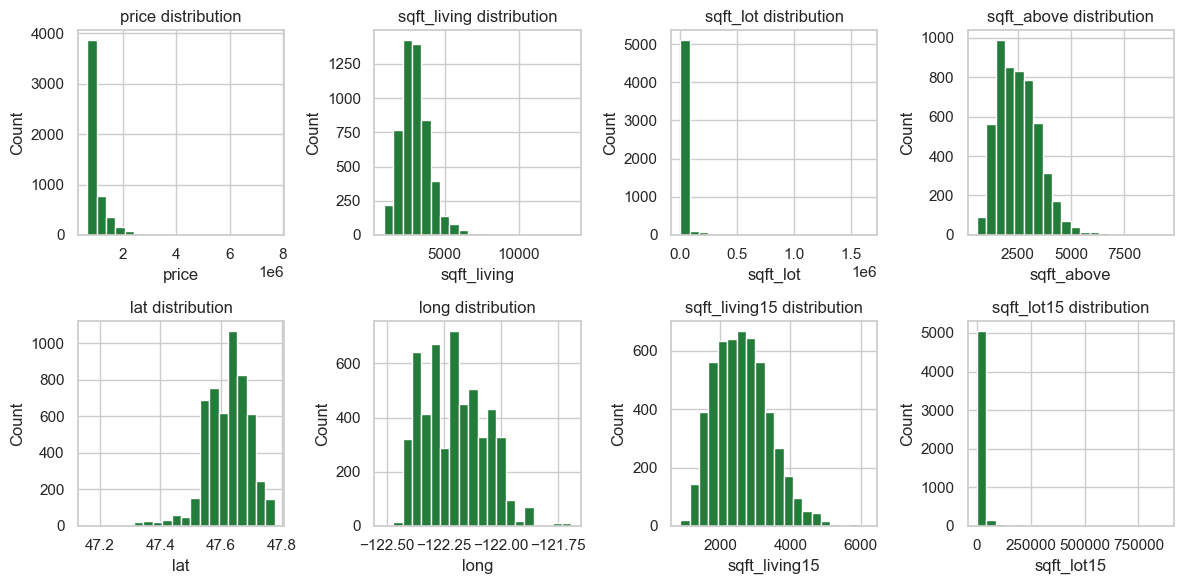

In [2933]:
mk_histplots(high_value,columns=labels_cont,sizex=4,sizey=2,figsize=(12,6),save='assets/hv_histplots.png',transp=True)

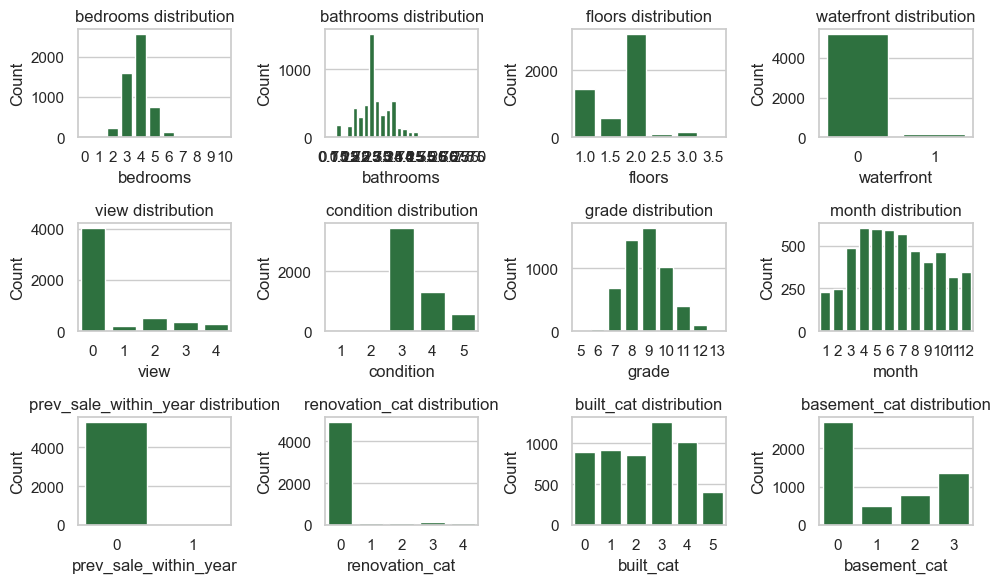

In [2934]:
mk_barplots(high_value,columns=labels_cat,figsize=(10,6),save='assets/hv_barplots.png',transp=True)

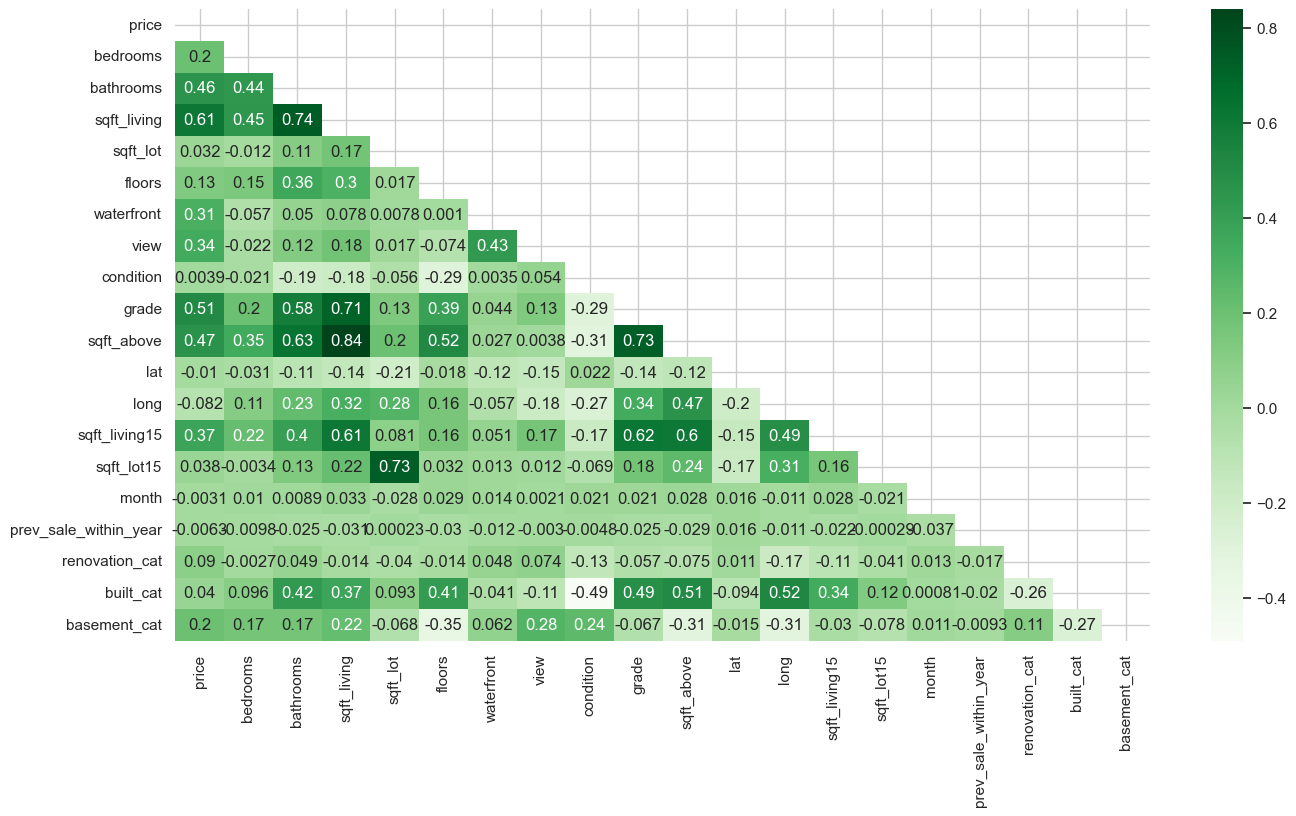

In [2951]:
plot_corrmatrix(high_value,figsize=(13,7),save='assets/hv_corrmatrix.png',transp=True)

## Fit an XGBoost model

In [2935]:
# splitting
X = high_value.drop(columns='price')
y = high_value['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=6,test_size=.2)

# no scaling applied since xgboost seemed to perform better without scaling

In [2936]:
hv_xgb_result_lst = []

In [2937]:
estim = 1
lr = 0.3
booster = 'gbtree'    # 'gbtree' (default), 'dart'
dart_nominalized_type = 'TREE'  # for dart booster: 'TREE' (default), 'FOREST'
min_child_weight = 1
max_depth = 6   # default 6
subsample = 1   # subsample ratio of the training instance, def 1.0
reg_alpha = 0   # def 0, L1 regularisation ()
reg_lambda = 1  # default 1, L2 regularisation (Lasso)
max_iterations = 20

alpha_lst = [0, 0.3, 0.5]
lambda_lst = [1, 0.75, 0.5]

for reg_alpha in alpha_lst:
    for reg_lambda in lambda_lst:
    
            # UNSCALED
            # labels
            xgb_model = xgb.XGBRegressor(random_state=1,
                                        n_estimator = estim,
                                        lr = lr,
                                        booster = booster,    # 'gbtree' (default), 'dart'
                                        dart_nominalized_type = dart_nominalized_type,  # for dart booster: 'TREE' (default), 'FOREST'
                                        min_child_weight = min_child_weight,
                                        max_depth = max_depth,   # default 6
                                        subsample = subsample,   # subsample ratio of the training instance, def 1.0
                                        reg_alpha = reg_alpha,   # def 0, L1 regularisation ()
                                        reg_lambda = reg_lambda,  # default 1, L2 regularisation (Lasso)
                                        max_iterations = max_iterations)
            xgb_model.fit(X_train, y_train)


            res = {'type': 'XGBoost',
                        'scaled': False,
                        'transform': 'labels',
                        'estimators': estim,
                        'booster': booster,
                        'dart_nominalized_type': dart_nominalized_type,
                        'min_child_weight': min_child_weight,
                        'max_depth': max_depth,
                        'reg_alpha': reg_alpha,
                        'reg_lambda': reg_lambda,
                        'learning rate': lr,
                        'subsample': subsample,
                        'max_iterations': max_iterations,
                        'dropped': 'day,zipcode,yr_renovated,yr_built',
                        'transformed': 'renovation_cat,built_cat,basement_cat'}
            res['r2-adj-train'],res['r2-adj-test'], res['mae-train'], res['mae-test'] = regression_report(xgb_model,X_train,X_test,y_train,y_test)

            # append results to result_lst
            hv_xgb_result_lst.append(res)

/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9903117646714187
r² adjusted: 0.9902683401677048
rMSE: 46576.737855393265
MAE: 33374.94182906786
ratio MAE/max(target): 0.0043

Metrics for test set

r²-score 0.7654840446329569
r² adjusted: 0.761220118171738
rMSE: 239662.3648672674
MAE: 132851.8041079812
ratio MAE/max(target): 0.0173



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9905831021333761
r² adjusted: 0.9905408938155026
rMSE: 45919.870914709005
MAE: 32780.37466247946
ratio MAE/max(target): 0.0043

Metrics for test set

r²-score 0.7635951495728444
r² adjusted: 0.7592968795650779
rMSE: 240625.60242938835
MAE: 132982.1006455399
ratio MAE/max(target): 0.0173



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9912746759886795
r² adjusted: 0.9912355674356681
rMSE: 44201.551142279044
MAE: 32328.22625616342
ratio MAE/max(target): 0.0042

Metrics for test set

r²-score 0.7222885312674495
r² adjusted: 0.7172392318359486
rMSE: 260801.77950135033
MAE: 135368.74430751175
ratio MAE/max(target): 0.0176



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9903117567495121
r² adjusted: 0.9902683322102908
rMSE: 46576.75689789574
MAE: 33374.962843390465
ratio MAE/max(target): 0.0043

Metrics for test set

r²-score 0.765484052639612
r² adjusted: 0.7612201263239685
rMSE: 239662.3607760876
MAE: 132851.79724178405
ratio MAE/max(target): 0.0173



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9905830952889196
r² adjusted: 0.990540886940368
rMSE: 45919.887602609066
MAE: 32780.391802653205
ratio MAE/max(target): 0.0043

Metrics for test set

r²-score 0.763595155105417
r² adjusted: 0.7592968851982428
rMSE: 240625.59961371298
MAE: 132982.09266431924
ratio MAE/max(target): 0.0173



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9912746679105982
r² adjusted: 0.9912355593213793
rMSE: 44201.571603618955
MAE: 32328.249471706975
ratio MAE/max(target): 0.0042

Metrics for test set

r²-score 0.7222885095366698
r² adjusted: 0.7172392097100638
rMSE: 260801.7897051527
MAE: 135368.74548122066
ratio MAE/max(target): 0.0176



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9903117531272609
r² adjusted: 0.990268328571804
rMSE: 46576.76560497969
MAE: 33374.973379901385
ratio MAE/max(target): 0.0043

Metrics for test set

r²-score 0.7654840796991376
r² adjusted: 0.7612201538754856
rMSE: 239662.346949416
MAE: 132851.79254694836
ratio MAE/max(target): 0.0173



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9905830888382332
r² adjusted: 0.9905408804607684
rMSE: 45919.903330428104
MAE: 32780.406139938954
ratio MAE/max(target): 0.0043

Metrics for test set

r²-score 0.7635951546236809
r² adjusted: 0.7592968847077478
rMSE: 240625.59985888147
MAE: 132982.0882629108
ratio MAE/max(target): 0.0173



/home/georg/studium/2024-Professional development/Courses/Ironhack/Data Science and ML/.iron-venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "dart_nominalized_type", "lr", "max_iterations", "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Metrics for training set

r²-score 0.9912746643301154
r² adjusted: 0.9912355557248481
rMSE: 44201.580672784046
MAE: 32328.25961199812
ratio MAE/max(target): 0.0042

Metrics for test set

r²-score 0.7222885329199237
r² adjusted: 0.7172392335184677
rMSE: 260801.77872542234
MAE: 135368.74647887325
ratio MAE/max(target): 0.0176



In [2938]:
hv_xgb_results=pd.DataFrame(hv_xgb_result_lst).sort_values(by=['r2-adj-test','mae-test'],ascending=[False,False])
hv_xgb_results

,type,scaled,transform,estimators,booster,dart_nominalized_type,min_child_weight,max_depth,reg_alpha,reg_lambda,learning rate,subsample,max_iterations,dropped,transformed,r2-adj-train,r2-adj-test,mae-train,mae-test
6,XGBoost,False,labels,1,gbtree,TREE,1,6,0.500000,1.000000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.990268,0.761220,33374.973380,132851.792547
3,XGBoost,False,labels,1,gbtree,TREE,1,6,0.300000,1.000000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.990268,0.761220,33374.962843,132851.797242
0,XGBoost,False,labels,1,gbtree,TREE,1,6,0.000000,1.000000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.990268,0.761220,33374.941829,132851.804108
4,XGBoost,False,labels,1,gbtree,TREE,1,6,0.300000,0.750000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.990541,0.759297,32780.391803,132982.092664
7,XGBoost,False,labels,1,gbtree,TREE,1,6,0.500000,0.750000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.990541,0.759297,32780.406140,132982.088263
1,XGBoost,False,labels,1,gbtree,TREE,1,6,0.000000,0.750000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.990541,0.759297,32780.374662,132982.100646
8,XGBoost,False,labels,1,gbtree,TREE,1,6,0.500000,0.500000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.991236,0.717239,32328.259612,135368.746479
2,XGBoost,False,labels,1,gbtree,TREE,1,6,0.000000,0.500000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.991236,0.717239,32328.226256,135368.744308
5,XGBoost,False,labels,1,gbtree,TREE,1,6,0.300000,0.500000,0.300000,1,20,"day,zipcode,yr_renovated,yr_built","renovation_cat,built_cat,basement_cat",0.991236,0.717239,32328.249472,135368.745481
